 Import all libraries

In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats
import shap
import warnings
import joblib
import os
import json
import zipfile
from google.colab import files
import time  # Added for timing evaluations

# Machine Learning imports
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           top_k_accuracy_score, mean_squared_error, mean_absolute_error,
                           r2_score, ConfusionMatrixDisplay)

# Suppress warnings
warnings.filterwarnings('ignore')

print("✅ All libraries successfully imported!")

✅ All libraries successfully imported!


Load and prepare data

In [ ]:
# Upload datasets
uploaded = files.upload()  # Upload food_nutrition.csv and user_history.csv

# Load datasets
df_nutrition = pd.read_csv('food_nutrition.csv')
df_history = pd.read_csv('user_history.csv')

print(f"✅ Nutrition dataset shape: {df_nutrition.shape}")
print(f"✅ User history dataset shape: {df_history.shape}")

# Clean column names
df_nutrition.columns = df_nutrition.columns.str.strip()
df_history.columns = df_history.columns.str.strip()

# Verify essential columns
assert 'food' in df_nutrition.columns, "Missing 'food' column in nutrition!"
assert 'food_type' in df_nutrition.columns, "Missing 'food_type' column in nutrition!"
assert 'User_ID' in df_history.columns, "Missing 'User_ID' column in history!"
assert 'food_type' in df_history.columns, "Missing 'food_type' column in history!"
assert 'Meal_Type' in df_history.columns, "Missing 'Meal_Type' column in history!"
assert 'Date' in df_history.columns, "Missing 'Date' column in history!"

# Convert Date to datetime format
df_history['Date'] = pd.to_datetime(df_history['Date'], errors='coerce')

# Basic dataset inspection
print("\n📋 Food types in nutrition dataset:")
print(df_nutrition['food_type'].unique())

print("\n📋 Food types in history dataset:")
print(df_history['food_type'].unique())

# Clean data
df_nutrition = df_nutrition.drop_duplicates(subset='food').reset_index(drop=True)
df_history = df_history.dropna(subset=['Date']).reset_index(drop=True)

# List of nutritional columns to use
all_nutrients = [
    'Caloric Value', 'Fat', 'Saturated Fats', 'Monounsaturated Fats', 'Polyunsaturated Fats',
    'Carbohydrates', 'Sugars', 'Protein', 'Dietary Fiber', 'Cholesterol', 'Sodium',
    'Vitamin A', 'Vitamin B1', 'Vitamin B11', 'Vitamin B12', 'Vitamin B2', 'Vitamin B3',
    'Vitamin B5', 'Vitamin B6', 'Vitamin C', 'Vitamin D', 'Vitamin E', 'Vitamin K',
    'Calcium', 'Iron', 'Copper', 'Magnesium', 'Manganese', 'Phosphorus', 'Potassium', 'Selenium', 'Zinc'
]

Saving food_nutrition.csv to food_nutrition (1).csv
Saving user_history.csv to user_history (1).csv
✅ Nutrition dataset shape: (932, 34)
✅ User history dataset shape: (10000, 4)

📋 Food types in nutrition dataset:
['Fruits' 'Vegetables' 'Meat' 'Dairy' 'Grains' 'Snacks' 'Beverages']

📋 Food types in history dataset:
['Meat' 'Fruits' 'Grains' 'Vegetables' 'Snacks' 'Beverages' 'Dairy']


Define nutritional priorities and limits

In [ ]:
# Define nutrition priorities for each emotion
nutrition_priorities = {}

def set_emotion_nutrition_priorities():
    nutrition_priorities['sad'] = [
        'Polyunsaturated Fats', 'Vitamin D', 'Protein', 'Vitamin B6', 'Vitamin B12', 'Magnesium', 'Zinc'
    ]
    nutrition_priorities['happy'] = [
        'Protein', 'Carbohydrates', 'Vitamin D', 'Polyunsaturated Fats', 'Magnesium'
    ]
    nutrition_priorities['angry'] = ['Magnesium', 'Vitamin C']
    nutrition_priorities['disgust'] = ['Dietary Fiber', 'Magnesium', 'Zinc', 'Vitamin B6']
    nutrition_priorities['neutral'] = [
        'Carbohydrates', 'Protein', 'Vitamin B1', 'Vitamin B2', 'Vitamin B3',
        'Vitamin B5', 'Vitamin B6', 'Vitamin B12', 'Magnesium', 'Zinc', 'Iron'
    ]
    nutrition_priorities['surprise'] = [
        'Carbohydrates', 'Vitamin B1', 'Vitamin B2', 'Vitamin B3', 'Vitamin B5',
        'Vitamin B6', 'Vitamin B12', 'Protein', 'Vitamin C', 'Vitamin D'
    ]
    nutrition_priorities['fear'] = ['Magnesium', 'Polyunsaturated Fats', 'Vitamin B6', 'Vitamin B12', 'Vitamin C']

set_emotion_nutrition_priorities()
print("✅ Nutrition priorities set.")

# Define general nutrition limits by age group
nutrition_general_limits = {
    'Caloric Value': {'child': 1800, 'adult': 3300},
    'Fat': {'child': 70000, 'adult': 128333.33},
    'Polyunsaturated Fats': {'child': 3000, 'adult': 3000},
    'Carbohydrates': {'child': 292500, 'adult': 536250},
    'Sugars': {'child': 45000, 'adult': 82500},
    'Protein': {'child': 27000, 'adult': 71000},
    'Dietary Fiber': {'child': 13000, 'adult': 30000},
    'Sodium': {'child': 1500, 'adult': 2000},
    'Vitamin A': {'child': 900, 'adult': 3000},
    'Vitamin B1': {'child': 0.7, 'adult': 1.4},
    'Vitamin B11': {'child': 0.4, 'adult': 1},
    'Vitamin B12': {'child': 0.0015, 'adult': 0.003},
    'Vitamin B2': {'child': 0.7, 'adult': 1.7},
    'Vitamin B3': {'child': 12, 'adult': 16},
    'Vitamin B5': {'child': 4, 'adult': 5},
    'Vitamin B6': {'child': 0.9, 'adult': 1.7},
    'Vitamin C': {'child': 50, 'adult': 100},
    'Vitamin D': {'child': 0.05, 'adult': 0.1},
    'Vitamin E': {'child': 100, 'adult': 300},
    'Vitamin K': {'child': 0.06, 'adult': 0.12},
    'Calcium': {'child': 1000, 'adult': 2500},
    'Iron': {'child': 10, 'adult': 18},
    'Copper': {'child': 0.7, 'adult': 0.9},
    'Magnesium': {'child': 200, 'adult': 420},
    'Manganese': {'child': 1.5, 'adult': 2.3},
    'Phosphorus': {'child': 800, 'adult': 1250},
    'Potassium': {'child': 2600, 'adult': 4700},
    'Zinc': {'child': 12, 'adult': 40}
}
print("✅ Nutrition limits defined.")

✅ Nutrition priorities set.
✅ Nutrition limits defined.


Utility functions

In [ ]:
# Function to check if food meets nutritional limits
def check_nutrient_limits(food_row, age_group='adult', tolerance=1.5):
    """
    Returns True if the food meets nutritional limits, False otherwise.
    """
    for nutrient, group_limits in nutrition_general_limits.items():
        if nutrient not in food_row:
            continue
        try:
            value = float(food_row[nutrient])
            limit = float(group_limits[age_group])
            if value > limit * tolerance:
                return False
        except:
            continue
    return True

# Improved compatibility score calculation
def calculate_compatibility_score(food_row, emotion, age_group='adult'):
    """
    Calculate compatibility score of food based on emotion with improved scaling
    """
    priority_nutrients = nutrition_priorities.get(emotion, [])
    if not priority_nutrients:
        return 0

    weights = np.linspace(1.0, 0.1, num=len(priority_nutrients))
    total_weight = np.sum(weights)
    score = 0

    for idx, nutrient in enumerate(priority_nutrients):
        if nutrient not in food_row:
            continue

        try:
            val = float(food_row.get(nutrient, 0))
            ideal = nutrition_general_limits.get(nutrient, {}).get(age_group, 1)
            ideal = float(ideal)

            if ideal > 0:
                # Calculate how close the value is to the ideal
                ratio = val / ideal
                if ratio > 2:  # More than double the ideal
                    factor = max(0, 1 - (ratio - 2) / 3)  # Penalty for excessive values
                elif ratio < 0.1:  # Less than 10% of ideal
                    factor = ratio * 2  # Small penalty for very low values
                else:
                    factor = 1 - min(1, abs(val - ideal) / ideal)

                score += (weights[idx] / total_weight) * factor * 10
        except:
            continue

    return round(score, 2)

# Calculate inverse compatibility for creating adversarial examples
def calculate_inverse_compatibility(food_row, emotion, age_group='adult'):
    """
    Calculate inverse compatibility to find foods that are NOT good for an emotion
    """
    # Get all emotions except the current one
    all_emotions = list(nutrition_priorities.keys())
    other_emotions = [e for e in all_emotions if e != emotion]

    # Calculate average score for other emotions
    other_scores = [calculate_compatibility_score(food_row, e, age_group) for e in other_emotions]
    avg_other_score = sum(other_scores) / len(other_scores) if other_scores else 0

    # Current emotion score
    current_score = calculate_compatibility_score(food_row, emotion, age_group)

    # If current score is low and other scores are high, this is a good inverse example
    inverse_score = avg_other_score - current_score

    return round(max(0, inverse_score), 2)

# Calculate food score with user history consideration
def calculate_food_score(row, emotion, age_group='adult', user_id=None):
    priority = nutrition_priorities.get(emotion, [])
    if not priority:
        return 0

    weights = np.linspace(1.0, 0.1, num=len(priority))
    total_score = 0.0
    total_weight = np.sum(weights)

    # Score based on priority nutrients
    for i, nutrient in enumerate(priority):
        if nutrient not in row:
            continue

        ideal_limit = nutrition_general_limits.get(nutrient, {}).get(age_group, None)
        food_val = row.get(nutrient, 0)

        if ideal_limit is None or ideal_limit == 0:
            continue

        try:
            food_val = float(food_val)
            ideal_limit = float(ideal_limit)

            # Better factor calculation with penalty for extreme values
            ratio = food_val / ideal_limit
            if ratio > 2:  # More than double the ideal
                factor = max(0, 1 - (ratio - 2) / 3)  # Penalty for excessive values
            elif ratio < 0.1:  # Less than 10% of ideal
                factor = ratio * 2  # Penalty for very low values
            else:
                factor = 1 - min(1, abs(food_val - ideal_limit) / ideal_limit)

            total_score += (weights[i] / total_weight) * factor * 10
        except:
            continue

    # Add score from user preferences if available
    if user_id and user_id in user_food_matrix:
        food_type = row.get('food_type')
        if food_type in user_food_matrix[user_id]:
            # Add score based on user history (max 2 points)
            user_preference_boost = min(2, user_food_matrix[user_id][food_type] / 5)
            total_score += user_preference_boost

    return round(total_score, 2)

print("✅ Utility functions created.")

✅ Utility functions created.



📊 ENHANCED EVALUATION: Generating Emotion-Food Type Analysis


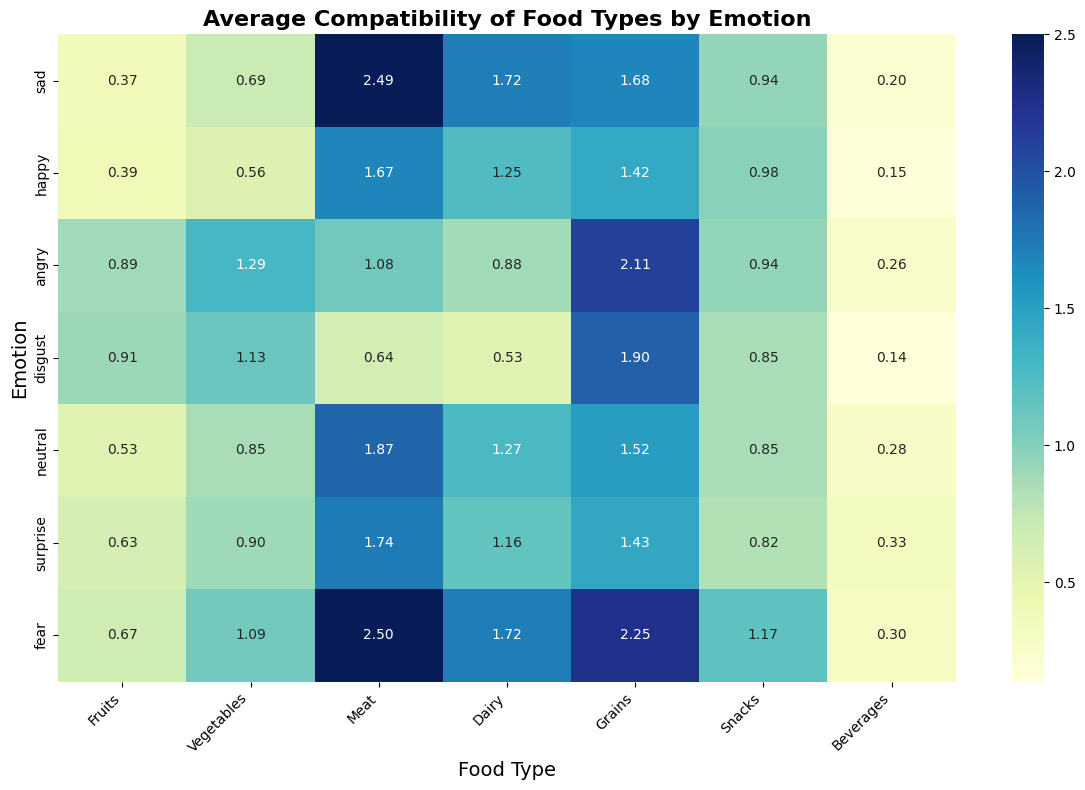

In [ ]:
# Emotion-Food Type Heatmap

def plot_emotion_food_heatmap():
    """
    Create heatmap showing which food types are recommended for each emotion
    """
    # Initialize data structure
    emotions = list(nutrition_priorities.keys())
    food_types = df_nutrition['food_type'].unique().tolist()

    # Create a 2D matrix to store recommendation strength
    scores = np.zeros((len(emotions), len(food_types)))

    # For each emotion and food type, calculate average compatibility score
    for i, emotion in enumerate(emotions):
        for j, food_type in enumerate(food_types):
            # Get foods of this type
            foods = df_nutrition[df_nutrition['food_type'] == food_type]

            # Calculate scores
            food_scores = []
            for _, food in foods.iterrows():
                score = calculate_compatibility_score(food, emotion, 'adult')
                food_scores.append(score)

            # Store average score
            scores[i, j] = np.mean(food_scores) if food_scores else 0

    # Create heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(scores, annot=True, fmt=".2f", cmap="YlGnBu",
                    xticklabels=food_types, yticklabels=emotions)

    plt.title("Average Compatibility of Food Types by Emotion", fontsize=16, fontweight='bold')
    plt.ylabel("Emotion", fontsize=14)
    plt.xlabel("Food Type", fontsize=14)

    # Rotate x labels
    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()

    return plt

print("\n📊 ENHANCED EVALUATION: Generating Emotion-Food Type Analysis")
emotion_food_plt = plot_emotion_food_heatmap()
emotion_food_plt.savefig('emotion_food_heatmap.png', dpi=300, bbox_inches='tight')
emotion_food_plt.show()

User trend analysis

In [ ]:
# Analyze user trends from history data
def analyze_user_trends():
    # Add month column for trend analysis
    df_history['Month'] = df_history['Date'].dt.month

    # Analyze trends by user and meal
    user_meal_preferences = {}
    for user_id in df_history['User_ID'].unique():
        user_data = df_history[df_history['User_ID'] == user_id]
        user_meal_preferences[user_id] = {}

        for meal_type in user_data['Meal_Type'].unique():
            meal_data = user_data[user_data['Meal_Type'] == meal_type]
            food_type_counts = meal_data['food_type'].value_counts(normalize=True)
            top_preferences = food_type_counts.head(3).to_dict()
            user_meal_preferences[user_id][meal_type] = top_preferences

    # Analyze trends by month
    monthly_trends = {}
    for month in df_history['Month'].unique():
        month_data = df_history[df_history['Month'] == month]
        food_type_counts = month_data['food_type'].value_counts(normalize=True)
        monthly_trends[month] = food_type_counts.head(5).to_dict()

    return user_meal_preferences, monthly_trends

# Analyze user-food relationships from history
def analyze_user_food_relations():
    user_food_relations = {}

    for user_id in df_history['User_ID'].unique():
        user_data = df_history[df_history['User_ID'] == user_id]
        food_type_counts = user_data['food_type'].value_counts()

        for food_type, count in food_type_counts.items():
            if user_id not in user_food_relations:
                user_food_relations[user_id] = {}
            user_food_relations[user_id][food_type] = count

    return user_food_relations

# Improved function to generate training data with ranking approach
def generate_training_data(num_samples=5000, foods_per_sample=10):
    """
    Generate training data with ranking approach
    - Each sample includes multiple foods for the same context (user, emotion, meal)
    - Foods are ranked by compatibility score
    """
    training_rows = []
    all_emotions = list(nutrition_priorities.keys())
    all_meal_times = df_history['Meal_Type'].dropna().unique().tolist()
    all_food_types = df_nutrition['food_type'].dropna().unique().tolist()
    user_ids = list(df_history['User_ID'].unique())

    # Analyze meal trends from user history
    food_type_meal_trends = {}
    for meal in all_meal_times:
        meal_data = df_history[df_history['Meal_Type'] == meal]
        if not meal_data.empty:
            counts = meal_data['food_type'].value_counts(normalize=True)
            food_type_meal_trends[meal] = counts.to_dict()

    # Create samples
    for _ in range(num_samples // foods_per_sample):  # Adjust to maintain total sample count
        # Create context: 1 user, 1 emotion, 1 meal time per batch
        user_id = random.choice(user_ids)
        age = random.randint(10, 50)
        age_group = 'child' if age <= 15 else 'adult'
        emotion = random.choice(all_emotions)
        meal_time = random.choice(all_meal_times)
        current_month = random.randint(1, 12)

        # Get valid foods (those meeting nutrition limits)
        valid_foods = df_nutrition[df_nutrition.apply(
            lambda row: check_nutrient_limits(row, age_group), axis=1
        )]

        if len(valid_foods) < foods_per_sample:
            continue

        # Calculate compatibility scores for all valid foods
        valid_foods = valid_foods.copy()
        valid_foods['compatibility_score'] = valid_foods.apply(
            lambda row: calculate_compatibility_score(row, emotion, age_group),
            axis=1
        )

        # Calculate inverse compatibility for creating adversarial examples
        valid_foods['inverse_score'] = valid_foods.apply(
            lambda row: calculate_inverse_compatibility(row, emotion, age_group),
            axis=1
        )

        # Get good foods (high compatibility)
        good_foods = valid_foods.nlargest(foods_per_sample // 2, 'compatibility_score')

        # Get bad foods (low compatibility, high inverse score)
        bad_foods = valid_foods.nlargest(foods_per_sample // 2, 'inverse_score')

        # Combine and shuffle
        sample_foods = pd.concat([good_foods, bad_foods]).sample(frac=1)

        # Only take the requested number of foods
        sample_foods = sample_foods.head(foods_per_sample)

        # Sort by compatibility score to get rankings
        sample_foods = sample_foods.sort_values(by='compatibility_score', ascending=False)

        # Assign ranks (1 is best)
        sample_foods['rank'] = range(1, len(sample_foods) + 1)

        # Create training data rows
        for _, row in sample_foods.iterrows():
            row_data = row[all_nutrients].to_dict()
            row_data['age'] = age
            row_data['Meal_Type'] = meal_time
            row_data['food_type'] = row['food_type']
            row_data['emotion'] = emotion
            row_data['label_food'] = row['food']
            row_data['user_id'] = user_id
            row_data['month'] = current_month
            row_data['compatibility_score'] = row['compatibility_score']
            row_data['rank'] = row['rank']
            row_data['is_good_match'] = 1 if row['rank'] <= foods_per_sample // 2 else 0  # Binary label

            training_rows.append(row_data)

    return pd.DataFrame(training_rows)

# Run the analysis
user_preferences, monthly_food_trends = analyze_user_trends()
user_food_matrix = analyze_user_food_relations()
print(f"✅ Analyzed trends for {len(user_preferences)} users and {len(monthly_food_trends)} months")
print(f"✅ Created user-food matrix for {len(user_food_matrix)} users")

✅ Analyzed trends for 1000 users and 12 months
✅ Created user-food matrix for 1000 users


Generate improved training data with ranking approach

In [ ]:
train_df = generate_training_data(num_samples=5000, foods_per_sample=10)
print(f"✅ Generated training dataset with shape: {train_df.shape}")
train_df.head()

✅ Generated training dataset with shape: (5000, 42)


,Caloric Value,Fat,Saturated Fats,Monounsaturated Fats,Polyunsaturated Fats,Carbohydrates,Sugars,Protein,Dietary Fiber,Cholesterol,...,age,Meal_Type,food_type,emotion,label_food,user_id,month,compatibility_score,rank,is_good_match
0,105.0,1900.0,240.0,1000.0,0.0,18000.0,0.0,8400.0,8100.0,0.0,...,36,Dinner,Grains,neutral,Baker's yeast,74,11,4.02,1,1
1,58.0,220.0,0.0,0.0,0.0,13000.0,12000.0,340.0,0.0,0.0,...,36,Dinner,Beverages,neutral,Rockstar energy drink,74,11,3.72,2,1
2,496.0,27000.0,17000.0,7900.0,670.0,38000.0,38000.0,26000.0,0.0,97.0,...,36,Dinner,Dairy,neutral,Powdered milk,74,11,3.25,3,1
3,466.0,30000.0,19000.0,7900.0,940.0,43000.0,0.0,9700.0,0.0,94.0,...,36,Dinner,Dairy,neutral,Brunost,74,11,3.21,4,1
4,149.0,2400.0,1100.0,550.0,130.0,0.0,0.0,30000.0,0.0,88.0,...,36,Dinner,Meat,neutral,Deer meat,74,11,2.93,5,1


Create a reduced test dataset for evaluation

In [ ]:
# Function to create a reduced dataset for testing
def create_reduced_dataset(df_nutrition, max_foods=150):
    """
    Create a smaller dataset for testing with max_foods foods while maintaining all food types
    """
    reduced_df = pd.DataFrame()
    food_types = df_nutrition['food_type'].unique()

    # Calculate foods per type to maintain balance
    foods_per_type = max(1, int(max_foods / len(food_types)))

    for food_type in food_types:
        foods_of_type = df_nutrition[df_nutrition['food_type'] == food_type]
        sample_size = min(foods_per_type, len(foods_of_type))
        sampled_foods = foods_of_type.sample(n=sample_size, random_state=42)
        reduced_df = pd.concat([reduced_df, sampled_foods])

    return reduced_df.reset_index(drop=True)

# Create reduced dataset
reduced_nutrition_df = create_reduced_dataset(df_nutrition, max_foods=150)
print(f"Created reduced dataset with {len(reduced_nutrition_df)} foods")
print("Distribution by food type:")
print(reduced_nutrition_df['food_type'].value_counts())

Created reduced dataset with 147 foods
Distribution by food type:
food_type
Fruits        21
Vegetables    21
Meat          21
Dairy         21
Grains        21
Snacks        21
Beverages     21
Name: count, dtype: int64


Encode and prepare data for model training

In [ ]:
# Encode categorical columns
meal_type_encoder = LabelEncoder()
food_type_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()
food_encoder = LabelEncoder()
user_encoder = LabelEncoder()

train_df['Meal_Type_encoded'] = meal_type_encoder.fit_transform(train_df['Meal_Type'])
train_df['food_type_encoded'] = food_type_encoder.fit_transform(train_df['food_type'])
train_df['emotion_encoded'] = emotion_encoder.fit_transform(train_df['emotion'])
train_df['label_food_encoded'] = food_encoder.fit_transform(train_df['label_food'])

# Encode user_id if available
if 'user_id' in train_df.columns:
    train_df['user_id_encoded'] = user_encoder.fit_transform(train_df['user_id'])

# Encode month if available
if 'month' in train_df.columns:
    train_df['month_encoded'] = train_df['month'] / 12  # Normalize month to 0-1

# Improved feature scaling with StandardScaler
scaler = StandardScaler()
scaled_nutrients = []

# Create a DataFrame to store scaled values
nutrients_to_scale = pd.DataFrame()

for nutrient in all_nutrients:
    if nutrient in train_df.columns:
        nutrients_to_scale[nutrient] = train_df[nutrient].astype(float)

# Apply scaling if we have nutrients
if not nutrients_to_scale.empty:
    # Handle NaN values
    nutrients_to_scale = nutrients_to_scale.fillna(0)

    # Apply scaler
    scaled_values = scaler.fit_transform(nutrients_to_scale)

    # Add scaled values back to dataframe
    for i, nutrient in enumerate(nutrients_to_scale.columns):
        scaled_name = f'{nutrient}_scaled'
        train_df[scaled_name] = scaled_values[:, i]
        scaled_nutrients.append(scaled_name)

# Create interaction features between emotion and priority nutrients
interaction_features = []
for emotion in train_df['emotion'].unique():
    priority_nutrients = nutrition_priorities.get(emotion, [])[:3]  # Top 3 priority nutrients
    for nutrient in priority_nutrients:
        feature_name = f'interaction_{emotion}_{nutrient}'
        scaled_name = f'{nutrient}_scaled'

        if scaled_name in train_df.columns:
            train_df[feature_name] = np.where(
                train_df['emotion'] == emotion,
                train_df[scaled_name],
                0
            )
            interaction_features.append(feature_name)

# Create user-food interaction features
user_food_features = []
if 'user_id_encoded' in train_df.columns:
    # User-food type interaction
    train_df['user_food_preference'] = train_df['user_id_encoded'] * train_df['food_type_encoded']
    user_food_features.append('user_food_preference')

    # User-emotion interaction
    train_df['user_emotion_pref'] = train_df['user_id_encoded'] * train_df['emotion_encoded']
    user_food_features.append('user_emotion_pref')

# Create seasonal features
seasonal_features = []
if 'month_encoded' in train_df.columns:
    # Create seasonal features (4 seasons)
    train_df['season'] = (train_df['month'] % 12) // 3
    train_df['season_encoded'] = train_df['season'] / 3  # Normalize to 0-1
    seasonal_features.append('season_encoded')

    # Season-emotion interaction
    train_df['season_emotion'] = train_df['season'] * train_df['emotion_encoded']
    seasonal_features.append('season_emotion')

# Create context features for LTR (Learning to Rank)
group_cols = ['user_id', 'emotion', 'Meal_Type']
if all(col in train_df.columns for col in group_cols):
    train_df['context_id'] = train_df.groupby(group_cols).ngroup()
    context_groups = train_df.groupby('context_id')['rank'].count().values

# Prepare X and y for different tasks
feature_cols = scaled_nutrients + interaction_features + user_food_features + seasonal_features + ['age', 'Meal_Type_encoded', 'food_type_encoded', 'emotion_encoded']
if 'user_id_encoded' in train_df.columns:
    feature_cols.append('user_id_encoded')
if 'month_encoded' in train_df.columns:
    feature_cols.append('month_encoded')

# Features for all tasks
X = train_df[feature_cols]

# Labels for different tasks
y_class = train_df['label_food_encoded']  # For classification
y_score = train_df['compatibility_score']  # For regression
y_rank = train_df['rank']                  # For ranking
y_binary = train_df['is_good_match']       # For binary classification

# Split into train/test sets
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
_, _, y_train_score, y_test_score = train_test_split(X, y_score, test_size=0.2, random_state=42)
_, _, y_train_rank, y_test_rank = train_test_split(X, y_rank, test_size=0.2, random_state=42)
_, _, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42)

print(f"✅ Training data shape: {X_train.shape}")
print(f"✅ Testing data shape: {X_test.shape}")

✅ Training data shape: (4000, 62)
✅ Testing data shape: (1000, 62)


Train the model

In [ ]:
# Train classification model for food recommendation
class_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
class_model.fit(X_train, y_train_class)
print("✅ Random Forest classification model trained")

# Train regression model for compatibility score prediction
reg_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
reg_model.fit(X_train, y_train_score)
print("✅ Random Forest regression model trained")

# Train rank model for predicting relative ranking
rank_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rank_model.fit(X_train, y_train_rank)
print("✅ Random Forest ranking model trained")

# Train binary classification model for good/bad match prediction
binary_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
binary_model.fit(X_train, y_train_binary)
print("✅ Random Forest binary classification model trained")

print("\n🔵 All models trained successfully!")

✅ Random Forest classification model trained
✅ Random Forest regression model trained
✅ Random Forest ranking model trained
✅ Random Forest binary classification model trained

🔵 All models trained successfully!


Evaluate model performance

In [ ]:
# Evaluate classification model
y_train_class_pred = class_model.predict(X_train)
y_test_class_pred = class_model.predict(X_test)

print("\n🔵 Food Classification Model Evaluation:")
print(f"Training accuracy: {accuracy_score(y_train_class, y_train_class_pred):.4f}")
print(f"Testing accuracy: {accuracy_score(y_test_class, y_test_class_pred):.4f}")

# Calculate top-3 accuracy for classification
def calculate_top_k_accuracy(model, X, y_true, k=3):
    proba = model.predict_proba(X)
    top_k_accuracy = 0
    for i, true_label in enumerate(y_true):
        pred_probs = proba[i]
        top_k_indices = pred_probs.argsort()[-k:][::-1]
        if true_label in top_k_indices:
            top_k_accuracy += 1
    return top_k_accuracy / len(y_true)

print(f"Top-3 Accuracy (Train): {calculate_top_k_accuracy(class_model, X_train, y_train_class, k=3):.4f}")
print(f"Top-3 Accuracy (Test): {calculate_top_k_accuracy(class_model, X_test, y_test_class, k=3):.4f}")

# Evaluate regression model
y_train_score_pred = reg_model.predict(X_train)
y_test_score_pred = reg_model.predict(X_test)

print("\n🔵 Compatibility Score Regression Model Evaluation:")
print(f"Training MSE: {mean_squared_error(y_train_score, y_train_score_pred):.4f}")
print(f"Testing MSE: {mean_squared_error(y_test_score, y_test_score_pred):.4f}")
print(f"Training R²: {r2_score(y_train_score, y_train_score_pred):.4f}")
print(f"Testing R²: {r2_score(y_test_score, y_test_score_pred):.4f}")

# Evaluate ranking model
y_train_rank_pred = rank_model.predict(X_train)
y_test_rank_pred = rank_model.predict(X_test)

print("\n🔵 Ranking Model Evaluation:")
print(f"Training MSE: {mean_squared_error(y_train_rank, y_train_rank_pred):.4f}")
print(f"Testing MSE: {mean_squared_error(y_test_rank, y_test_rank_pred):.4f}")
print(f"Training R²: {r2_score(y_train_rank, y_train_rank_pred):.4f}")
print(f"Testing R²: {r2_score(y_test_rank, y_test_rank_pred):.4f}")

# Evaluate binary classification model
y_train_binary_pred = binary_model.predict(X_train)
y_test_binary_pred = binary_model.predict(X_test)

print("\n🔵 Binary Classification Model Evaluation:")
print(f"Training accuracy: {accuracy_score(y_train_binary, y_train_binary_pred):.4f}")
print(f"Testing accuracy: {accuracy_score(y_test_binary, y_test_binary_pred):.4f}")

# Show feature importance for all models
print("\n🔍 Top 15 most important features for classification model:")
feat_importances = class_model.feature_importances_
indices = np.argsort(feat_importances)[-15:]
for i in reversed(indices):
    print(f"{feature_cols[i]}: {feat_importances[i]:.4f}")

print("\n🔍 Top 15 most important features for regression model:")
reg_feat_importances = reg_model.feature_importances_
indices = np.argsort(reg_feat_importances)[-15:]
for i in reversed(indices):
    print(f"{feature_cols[i]}: {reg_feat_importances[i]:.4f}")

print("\n🔍 Top 15 most important features for ranking model:")
rank_feat_importances = rank_model.feature_importances_
indices = np.argsort(rank_feat_importances)[-15:]
for i in reversed(indices):
    print(f"{feature_cols[i]}: {rank_feat_importances[i]:.4f}")


🔵 Food Classification Model Evaluation:
Training accuracy: 1.0000
Testing accuracy: 1.0000
Top-3 Accuracy (Train): 1.0000
Top-3 Accuracy (Test): 1.0000

🔵 Compatibility Score Regression Model Evaluation:
Training MSE: 0.0242
Testing MSE: 0.0276
Training R²: 0.9935
Testing R²: 0.9930

🔵 Ranking Model Evaluation:
Training MSE: 0.2093
Testing MSE: 0.2436
Training R²: 0.9748
Testing R²: 0.9699

🔵 Binary Classification Model Evaluation:
Training accuracy: 1.0000
Testing accuracy: 0.9990

🔍 Top 15 most important features for classification model:
Caloric Value_scaled: 0.0407
Sodium_scaled: 0.0369
Calcium_scaled: 0.0364
Vitamin B1_scaled: 0.0350
Vitamin A_scaled: 0.0343
Selenium_scaled: 0.0334
Carbohydrates_scaled: 0.0334
Protein_scaled: 0.0322
Potassium_scaled: 0.0307
Vitamin B3_scaled: 0.0306
Phosphorus_scaled: 0.0300
Iron_scaled: 0.0285
Zinc_scaled: 0.0278
Monounsaturated Fats_scaled: 0.0271
Polyunsaturated Fats_scaled: 0.0270

🔍 Top 15 most important features for regression model:
intera


📊 ENHANCED EVALUATION: Visualizing Feature Importance


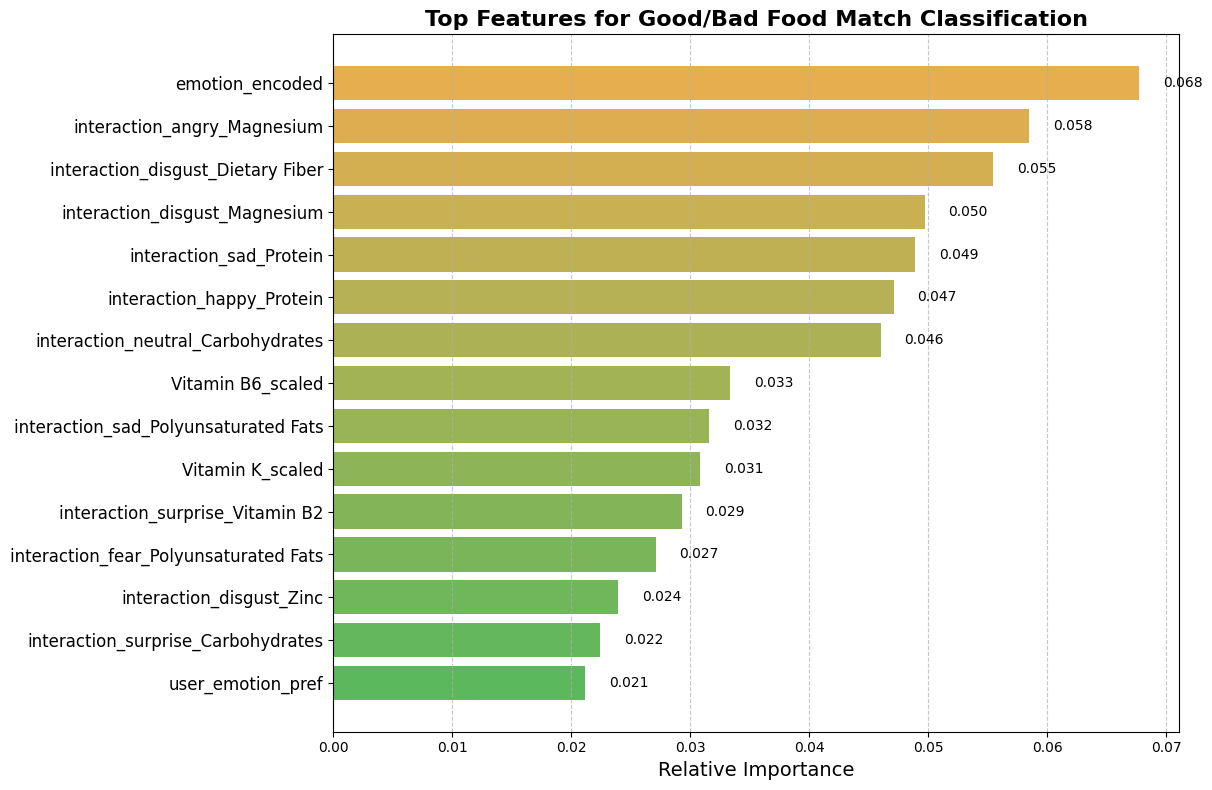

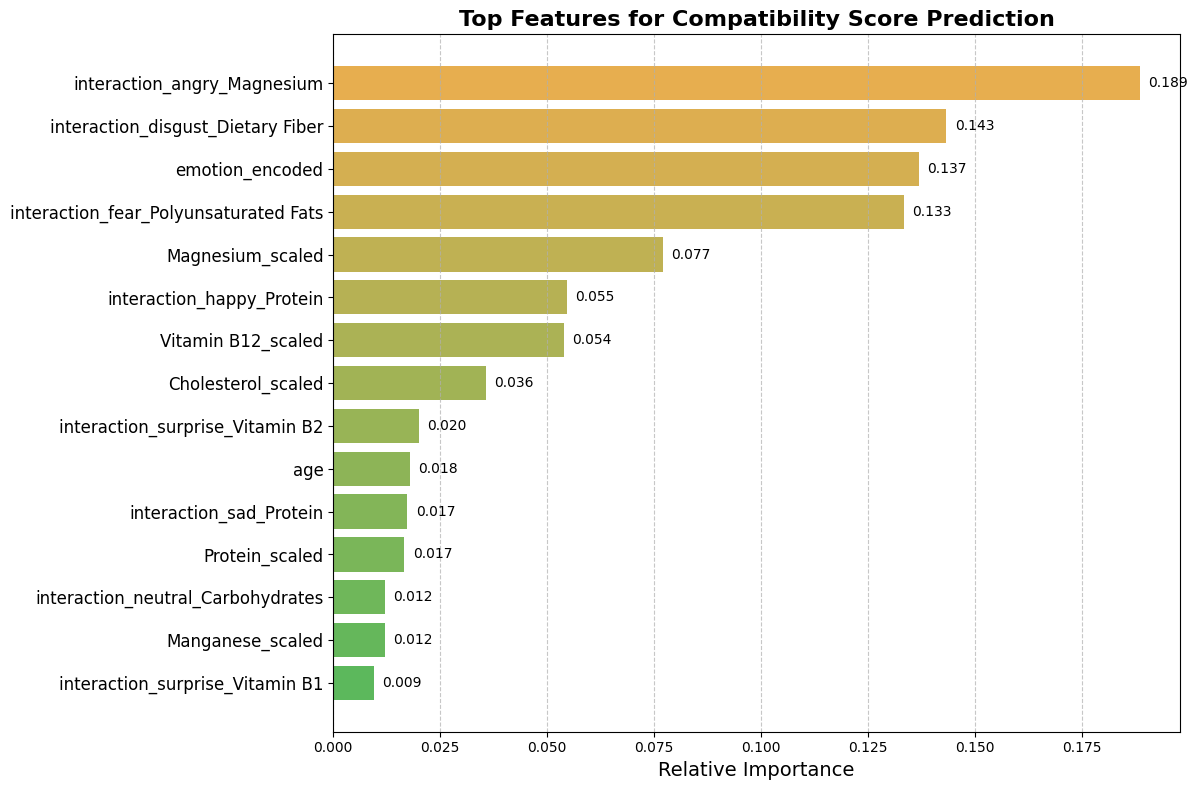

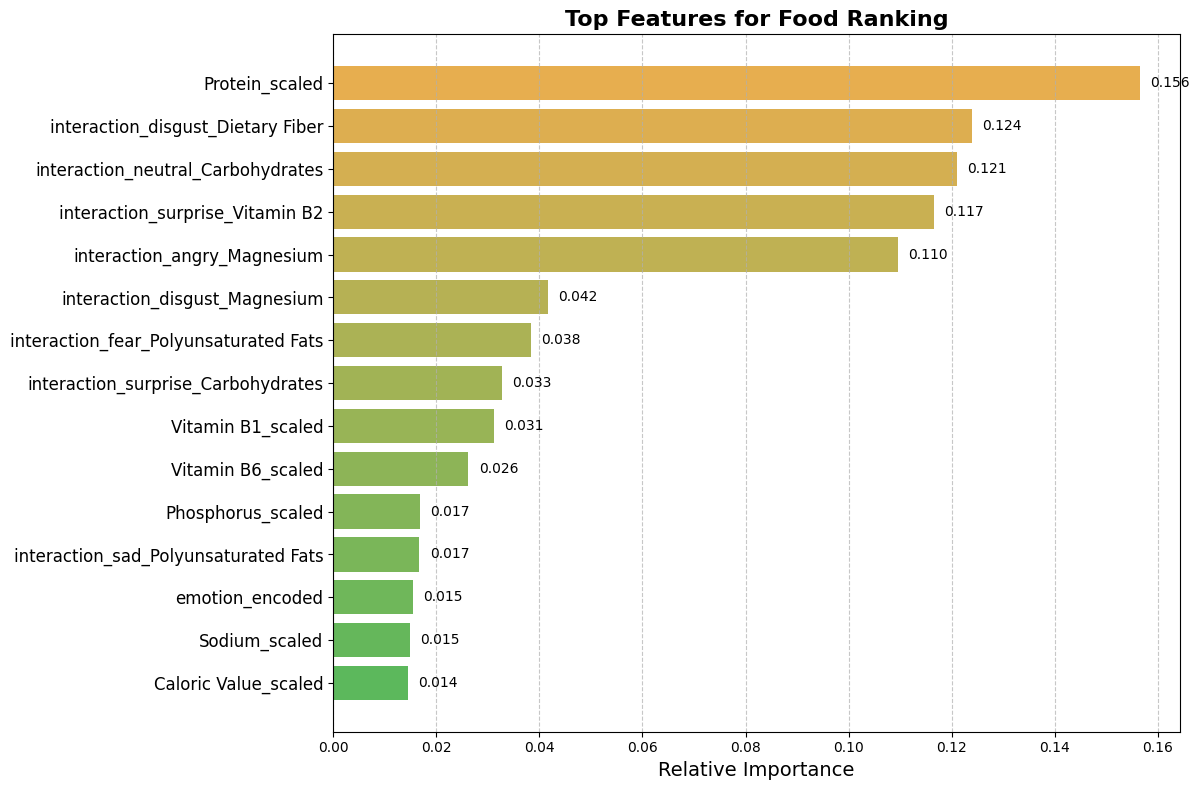

In [ ]:
#Feature Importance Visualization with Better Styling

def plot_feature_importance(model, feature_names, title, top_n=15, figsize=(12, 8)):
    """
    Create an enhanced feature importance plot
    """
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]

    # Create custom colormap (green to orange gradient)
    colors = ["#5cb85c", "#f0ad4e"]
    cmap = LinearSegmentedColormap.from_list("custom_importance", colors, N=100)

    # Create figure
    plt.figure(figsize=figsize)

    # Plot horizontal bars
    bars = plt.barh(range(len(indices)), importances[indices], color=[cmap(i/len(indices)) for i in range(len(indices))])

    # Add feature names and styling
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=12)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Add grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Add value labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
                 f'{importances[indices[i]]:.3f}',
                 va='center', fontsize=10)

    return plt

print("\n📊 ENHANCED EVALUATION: Visualizing Feature Importance")

# For binary classification model
plt_binary = plot_feature_importance(
    binary_model,
    feature_cols,
    "Top Features for Good/Bad Food Match Classification",
    top_n=15
)
plt_binary.savefig('binary_feature_importance.png', dpi=300, bbox_inches='tight')
plt_binary.show()

# For regression model
plt_reg = plot_feature_importance(
    reg_model,
    feature_cols,
    "Top Features for Compatibility Score Prediction",
    top_n=15
)
plt_reg.savefig('regression_feature_importance.png', dpi=300, bbox_inches='tight')
plt_reg.show()

# For ranking model
plt_rank = plot_feature_importance(
    rank_model,
    feature_cols,
    "Top Features for Food Ranking",
    top_n=15
)
plt_rank.savefig('ranking_feature_importance.png', dpi=300, bbox_inches='tight')
plt_rank.show()


📊 ENHANCED EVALUATION: Generating Confusion Matrix


<Figure size 800x600 with 0 Axes>

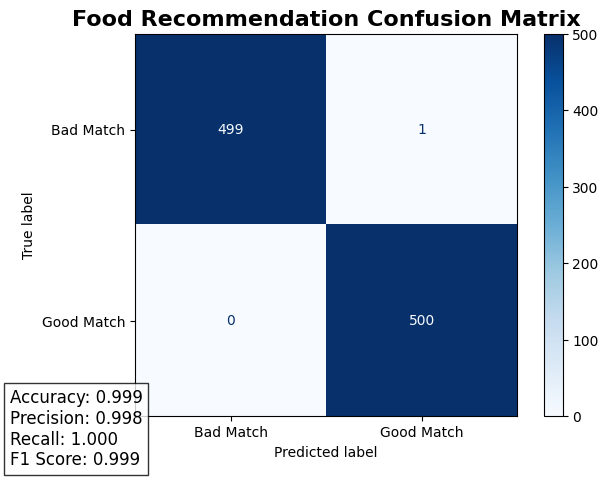

In [ ]:
# Confusion Matrix for Binary Classification

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Plot confusion matrix with better styling
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))

    # Create a custom colormap (Blues)
    cmap = plt.cm.Blues

    # Plot the confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap=cmap)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(False)
    plt.tight_layout()

    # Calculate and display metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics_text = f"Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1 Score: {f1:.3f}"
    plt.figtext(0.02, 0.02, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    return plt

print("\n📊 ENHANCED EVALUATION: Generating Confusion Matrix")
y_pred_binary = binary_model.predict(X_test)
cm_plt = plot_confusion_matrix(
    y_test_binary,
    y_pred_binary,
    labels=["Bad Match", "Good Match"],
    title="Food Recommendation Confusion Matrix"
)
cm_plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
cm_plt.show()


📊 ENHANCED EVALUATION: Generating Learning Curves


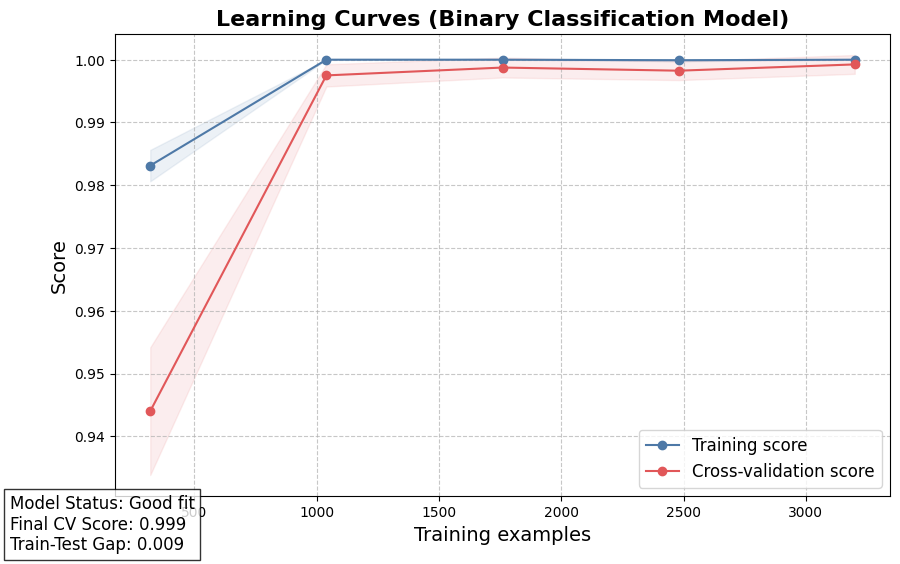

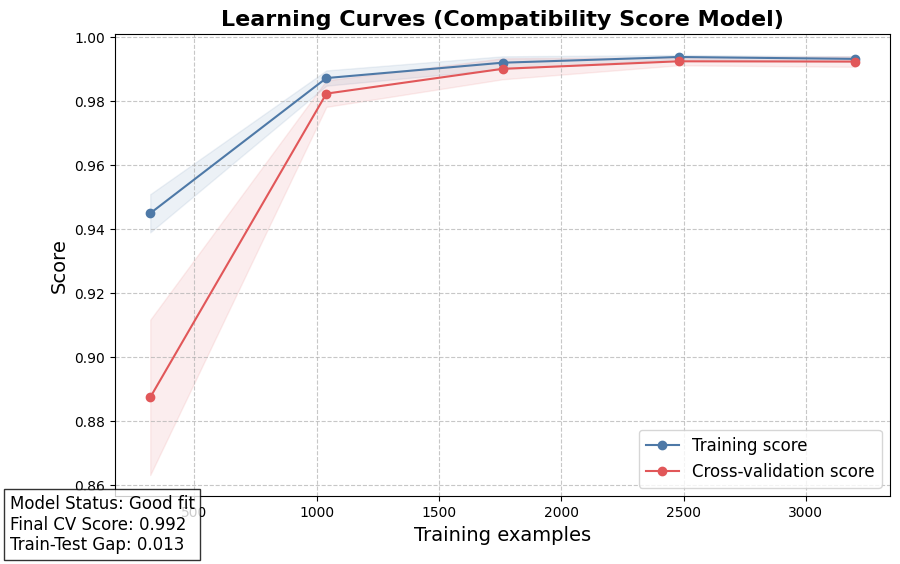

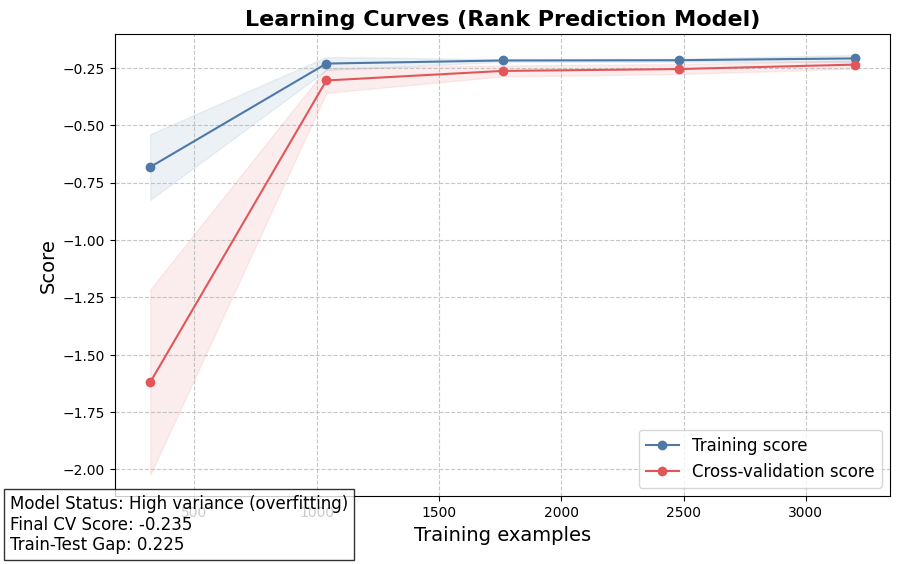

In [ ]:
# Learning Curves

def plot_learning_curve(estimator, X, y, title, ylim=None, cv=5, n_jobs=-1,
                        train_sizes=np.linspace(.1, 1.0, 5), scoring=None,
                        figsize=(10, 6)):
    """
    Generate a plot of training and validation learning curves.
    """
    plt.figure(figsize=figsize)

    if ylim is not None:
        plt.ylim(*ylim)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Training examples", fontsize=14)
    plt.ylabel("Score", fontsize=14)

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot training mean and fill with std
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="#4e79a7")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#4e79a7",
             label="Training score")

    # Plot testing mean and fill with std
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#e15759")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#e15759",
             label="Cross-validation score")

    plt.grid(linestyle='--', alpha=0.7)
    plt.legend(loc="best", fontsize=12)

    # Add analysis text based on the curves
    gap = np.mean(train_scores_mean - test_scores_mean)
    test_final = test_scores_mean[-1]
    train_final = train_scores_mean[-1]

    if gap > 0.1:
        status = "High variance (overfitting)"
    elif test_final < 0.75:
        status = "High bias (underfitting)"
    else:
        status = "Good fit"

    metrics_text = (f"Model Status: {status}\n"
                    f"Final CV Score: {test_final:.3f}\n"
                    f"Train-Test Gap: {gap:.3f}")

    plt.figtext(0.02, 0.02, metrics_text, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8))

    return plt

print("\n📊 ENHANCED EVALUATION: Generating Learning Curves")

# For binary classification model (accuracy)
lc_plt_binary = plot_learning_curve(
    binary_model, X_train, y_train_binary,
    "Learning Curves (Binary Classification Model)",
    scoring='accuracy'
)
lc_plt_binary.savefig('learning_curve_binary.png', dpi=300, bbox_inches='tight')
lc_plt_binary.show()

# For regression model (R2)
lc_plt_reg = plot_learning_curve(
    reg_model, X_train, y_train_score,
    "Learning Curves (Compatibility Score Model)",
    scoring='r2'
)
lc_plt_reg.savefig('learning_curve_regression.png', dpi=300, bbox_inches='tight')
lc_plt_reg.show()

# For ranking model (mean squared error, negated for scoring)
lc_plt_rank = plot_learning_curve(
    rank_model, X_train, y_train_rank,
    "Learning Curves (Rank Prediction Model)",
    scoring='neg_mean_squared_error'
)
lc_plt_rank.savefig('learning_curve_ranking.png', dpi=300, bbox_inches='tight')
lc_plt_rank.show()

Evaluation of model recommendations quality vs. direct scoring

In [ ]:
def create_feature_vector(food_row, emotion, meal_type, age):
    """
    Create a feature vector from food information and context
    """
    # Initialize feature vector
    feature_vector = np.zeros(len(feature_cols))

    # Process nutrition data
    nutrient_features = {}
    for nutrient in all_nutrients:
        # Handle missing values
        if nutrient not in food_row:
            nutrient_features[nutrient] = 0
        else:
            try:
                nutrient_features[nutrient] = float(food_row[nutrient])
            except:
                nutrient_features[nutrient] = 0

    # Scale nutrition values
    if not nutrients_to_scale.empty:
        nutrient_df = pd.DataFrame([nutrient_features])
        # Ensure columns match with what the scaler was trained on
        for col in nutrients_to_scale.columns:
            if col not in nutrient_df.columns:
                nutrient_df[col] = 0
        nutrient_df = nutrient_df[nutrients_to_scale.columns]
        scaled_nutrient_vals = scaler.transform(nutrient_df)[0]

        # Fill in values to feature vector
        for i, nutrient in enumerate(all_nutrients):
            if i < len(scaled_nutrient_vals):
                scaled_name = f'{nutrient}_scaled'
                if scaled_name in feature_cols:
                    idx = feature_cols.index(scaled_name)
                    feature_vector[idx] = scaled_nutrient_vals[i]

    # Fill in basic information
    for i, col in enumerate(feature_cols):
        if col == 'age':
            feature_vector[i] = age
        elif col == 'Meal_Type_encoded':
            if meal_type in meal_type_encoder.classes_:
                feature_vector[i] = meal_type_encoder.transform([meal_type])[0]
        elif col == 'emotion_encoded':
            if emotion in emotion_encoder.classes_:
                feature_vector[i] = emotion_encoder.transform([emotion])[0]
        elif col == 'food_type_encoded':
            food_type = food_row['food_type']
            if food_type in food_type_encoder.classes_:
                feature_vector[i] = food_type_encoder.transform([food_type])[0]
        elif col == 'month_encoded':
            feature_vector[i] = 0.5  # Default value

    # Create interaction features
    for e in nutrition_priorities.keys():
        priority_nutrients = nutrition_priorities.get(e, [])[:3]
        for nutrient in priority_nutrients:
            feature_name = f'interaction_{e}_{nutrient}'
            if feature_name in feature_cols:
                idx = feature_cols.index(feature_name)
                if e == emotion:
                    # Get scaled nutrient value
                    scaled_name = f'{nutrient}_scaled'
                    if scaled_name in feature_cols:
                        scaled_idx = feature_cols.index(scaled_name)
                        feature_vector[idx] = feature_vector[scaled_idx]
                else:
                    feature_vector[idx] = 0

    return feature_vector

In [ ]:
# Parallel approach with direct scoring for final sorting
def parallel_with_direct_scoring(emotion, meal_type, age, num_recommendations=5, reduced_df=None, food_type=None):
    """
    Parallel approach but uses direct scoring for final sorting:
    1. Get separate recommendations from each model
    2. Combine and create consensus ranking
    3. Final ordering based on direct scoring
    """
    # Use reduced_df if provided, otherwise use df_nutrition
    df_to_use = reduced_df if reduced_df is not None else df_nutrition

    # Additional filtering by food_type if specified
    if food_type:
        df_to_use = df_to_use[df_to_use['food_type'] == food_type]

    # Filter by nutrition limits
    valid_foods = df_to_use[df_to_use.apply(
        lambda row: check_nutrient_limits(row, 'adult' if age > 15 else 'child'), axis=1
    )]

    if valid_foods.empty:
        return []

    # For stats tracking
    stats = {"valid_foods": len(valid_foods)}

    # Process all valid foods through each model
    food_scores = {}

    for _, food_row in valid_foods.iterrows():
        food_name = food_row['food']
        food_type_val = food_row['food_type']

        if food_type_val not in food_type_encoder.classes_:
            continue

        feature_vector = create_feature_vector(food_row, emotion, meal_type, age)

        # Get scores from all models
        rank_prediction = rank_model.predict([feature_vector])[0]
        binary_score = binary_model.predict_proba([feature_vector])[0][1]
        reg_score = reg_model.predict([feature_vector])[0]

        # Calculate direct score
        direct_score = calculate_compatibility_score(food_row, emotion, 'adult' if age > 15 else 'child')

        food_scores[food_name] = {
            'food': food_name,
            'food_type': food_type_val,
            'rank_score': rank_prediction,  # Lower is better
            'binary_score': binary_score,   # Higher is better
            'reg_score': reg_score,         # Higher is better
            'direct_score': direct_score,   # Higher is better
            'feature_vector': feature_vector,
            'food_row': food_row
        }

    # Exit if no valid foods were processed
    if not food_scores:
        return []

    # Get top recommendations by each model
    top_by_rank = sorted(food_scores.values(), key=lambda x: x['rank_score'])[:5]
    top_by_binary = sorted(food_scores.values(), key=lambda x: x['binary_score'], reverse=True)[:5]
    top_by_reg = sorted(food_scores.values(), key=lambda x: x['reg_score'], reverse=True)[:5]

    # Create a set of unique foods from all models
    unique_foods = {}

    # Add foods with their "votes" (appearance count)
    for food in top_by_rank + top_by_binary + top_by_reg:
        name = food['food']
        if name in unique_foods:
            unique_foods[name]['votes'] += 1
        else:
            unique_foods[name] = food.copy()
            unique_foods[name]['votes'] = 1

    # Create consensus ranking based on:
    # 1. Number of votes (how many models selected it)
    # 2. Average normalized position across models
    for name, food in unique_foods.items():
        # Calculate average position
        rank_pos = next((i+1 for i, f in enumerate(top_by_rank) if f['food'] == name), 999)
        binary_pos = next((i+1 for i, f in enumerate(top_by_binary) if f['food'] == name), 999)
        reg_pos = next((i+1 for i, f in enumerate(top_by_reg) if f['food'] == name), 999)

        # Normalize to 0-1 where 0 is best
        positions = []
        if rank_pos <= 5: positions.append((rank_pos-1)/4)
        if binary_pos <= 5: positions.append((binary_pos-1)/4)
        if reg_pos <= 5: positions.append((reg_pos-1)/4)

        food['avg_position'] = sum(positions)/len(positions) if positions else 1.0

        # Calculate consensus score: higher vote count is better, lower position is better
        food['consensus_score'] = food['votes'] - food['avg_position']

    # Identify top candidates by consensus
    consensus_candidates = sorted(unique_foods.values(),
                               key=lambda x: (x['votes'], -x['avg_position']),
                               reverse=True)[:10]  # Take top 10 by consensus

    # FINAL STEP: Use direct scoring to sort the consensus candidates
    final_sorted = sorted(consensus_candidates, key=lambda x: x['direct_score'], reverse=True)

    # Prepare results
    results = []
    for i, food in enumerate(final_sorted[:num_recommendations]):
        results.append({
            'food': food['food'],
            'food_type': food['food_type'],
            'binary_score': food['binary_score'] * 10,  # Scale to 0-10
            'rank_score': 10 - min(10, food['rank_score']), # Convert to 0-10 where higher is better
            'reg_score': food['reg_score'],
            'direct_score': food['direct_score'],
            'votes': food['votes'],
            'avg_position': food['avg_position'],
            'consensus_score': food['consensus_score'],
            'pipeline_stats': {
                "valid_foods": stats["valid_foods"],
                "unique_recommendations": len(unique_foods),
                "consensus_candidates": len(consensus_candidates)
            }
        })

    return results

In [ ]:
# First evaluation: Compare with full and reduced dataset
def evaluate_on_both_datasets_final(n_tests=10):
    """
    Evaluate the Parallel+Direct approach on both full and reduced datasets
    """
    print("\n🔍 EVALUATION: Parallel+Direct approach on full vs reduced dataset")

    # Track metrics
    metrics = {
        "full": {"top1_matches": 0, "top3_overlap_total": 0, "avg_time": 0},
        "reduced": {"top1_matches": 0, "top3_overlap_total": 0, "avg_time": 0}
    }

    # Test with variety of contexts
    emotions = list(nutrition_priorities.keys())
    meal_types = ['Breakfast', 'Lunch', 'Snack', 'Dinner']
    food_types = df_nutrition['food_type'].unique().tolist()
    ages = [12, 25, 35, 50]

    # Run tests
    for i in range(n_tests):
        emotion = random.choice(emotions)
        meal = random.choice(meal_types)
        food_type = random.choice(food_types)
        age = random.choice(ages)

        print(f"\n🧪 Test {i+1}")
        print(f"Context: Emotion={emotion}, Meal={meal}, Food Type={food_type}, Age={age}")

        # ---------- EVALUATION ON FULL DATASET ----------
        print("\n📊 FULL DATASET EVALUATION:")

        # Get direct scores for reference (full dataset)
        full_direct_recs = []
        for _, row in df_nutrition[df_nutrition['food_type'] == food_type].iterrows():
            if check_nutrient_limits(row, 'adult' if age > 15 else 'child'):
                score = calculate_compatibility_score(row, emotion, 'adult' if age > 15 else 'child')
                full_direct_recs.append({
                    'food': row['food'],
                    'food_type': row['food_type'],
                    'score': score
                })

        # Sort by direct score
        full_direct_recs.sort(key=lambda x: x['score'], reverse=True)

        # Extract direct recommendations
        if full_direct_recs:
            full_direct_top1 = full_direct_recs[0]['food']
            full_direct_top3 = [r['food'] for r in full_direct_recs[:3]]
            print(f"Direct top 3: {full_direct_top3}")
        else:
            print(f"No valid foods found for {food_type}")
            continue

        # Test Parallel+Direct approach on full dataset
        start_time = time.time()
        full_recs = parallel_with_direct_scoring(
            emotion, meal, age,
            num_recommendations=5,
            food_type=food_type,
            reduced_df=None  # Use full dataset
        )
        full_time = time.time() - start_time

        # Process results
        if full_recs:
            full_top1 = full_recs[0]['food']
            full_top3 = [r['food'] for r in full_recs[:min(3, len(full_recs))]]
            full_top1_match = full_top1 == full_direct_top1
            full_top3_overlap = len(set(full_top3) & set(full_direct_top3))

            if full_top1_match:
                metrics["full"]["top1_matches"] += 1
            metrics["full"]["top3_overlap_total"] += full_top3_overlap / min(3, len(full_direct_top3))
            metrics["full"]["avg_time"] += full_time

            print(f"Parallel+Direct top 3: {full_top3}")
            print(f"  Top 1 match: {'✅' if full_top1_match else '❌'}")
            print(f"  Top 3 overlap: {full_top3_overlap}/{min(3, len(full_direct_top3))} ({full_top3_overlap/min(3, len(full_direct_top3)):.2%})")
            print(f"  Time: {full_time:.4f}s")

            # Print details
            print("  Details for top recommendation:")
            print(f"    Votes: {full_recs[0].get('votes', 'N/A')}/3")
            print(f"    Direct score: {full_recs[0].get('direct_score', 'N/A'):.2f}")
        else:
            print("No recommendations returned")

        # ---------- EVALUATION ON REDUCED DATASET ----------
        print("\n📊 REDUCED DATASET EVALUATION:")

        # Get direct scores for reference (reduced dataset)
        reduced_df_filtered = reduced_nutrition_df[reduced_nutrition_df['food_type'] == food_type]
        reduced_direct_recs = []
        for _, row in reduced_df_filtered.iterrows():
            if check_nutrient_limits(row, 'adult' if age > 15 else 'child'):
                score = calculate_compatibility_score(row, emotion, 'adult' if age > 15 else 'child')
                reduced_direct_recs.append({
                    'food': row['food'],
                    'food_type': row['food_type'],
                    'score': score
                })

        # Sort by direct score
        reduced_direct_recs.sort(key=lambda x: x['score'], reverse=True)

        # Extract direct recommendations
        if reduced_direct_recs:
            reduced_direct_top1 = reduced_direct_recs[0]['food']
            reduced_direct_top3 = [r['food'] for r in reduced_direct_recs[:3]]
            print(f"Direct top 3: {reduced_direct_top3}")
        else:
            print(f"No valid foods found for {food_type}")
            continue

        # Test Parallel+Direct approach on reduced dataset
        start_time = time.time()
        reduced_recs = parallel_with_direct_scoring(
            emotion, meal, age,
            num_recommendations=5,
            food_type=food_type,
            reduced_df=reduced_nutrition_df  # Use reduced dataset
        )
        reduced_time = time.time() - start_time

        # Process results
        if reduced_recs:
            reduced_top1 = reduced_recs[0]['food']
            reduced_top3 = [r['food'] for r in reduced_recs[:min(3, len(reduced_recs))]]
            reduced_top1_match = reduced_top1 == reduced_direct_top1
            reduced_top3_overlap = len(set(reduced_top3) & set(reduced_direct_top3))

            if reduced_top1_match:
                metrics["reduced"]["top1_matches"] += 1
            metrics["reduced"]["top3_overlap_total"] += reduced_top3_overlap / min(3, len(reduced_direct_top3))
            metrics["reduced"]["avg_time"] += reduced_time

            print(f"Parallel+Direct top 3: {reduced_top3}")
            print(f"  Top 1 match: {'✅' if reduced_top1_match else '❌'}")
            print(f"  Top 3 overlap: {reduced_top3_overlap}/{min(3, len(reduced_direct_top3))} ({reduced_top3_overlap/min(3, len(reduced_direct_top3)):.2%})")
            print(f"  Time: {reduced_time:.4f}s")

            # Print details
            print("  Details for top recommendation:")
            print(f"    Votes: {reduced_recs[0].get('votes', 'N/A')}/3")
            print(f"    Direct score: {reduced_recs[0].get('direct_score', 'N/A'):.2f}")
        else:
            print("No recommendations returned")

    # Calculate averages
    if n_tests > 0:
        for dataset in metrics:
            metrics[dataset]["avg_time"] /= n_tests

    # Print summary
    print("\n🏁 OVERALL RESULTS:")
    print(f"Full dataset:")
    print(f"  Top 1 Accuracy: {metrics['full']['top1_matches']/n_tests:.2%} ({metrics['full']['top1_matches']}/{n_tests})")
    print(f"  Average Top 3 Overlap: {metrics['full']['top3_overlap_total']/n_tests:.2%}")
    print(f"  Average execution time: {metrics['full']['avg_time']:.4f}s")

    print(f"Reduced dataset:")
    print(f"  Top 1 Accuracy: {metrics['reduced']['top1_matches']/n_tests:.2%} ({metrics['reduced']['top1_matches']}/{n_tests})")
    print(f"  Average Top 3 Overlap: {metrics['reduced']['top3_overlap_total']/n_tests:.2%}")
    print(f"  Average execution time: {metrics['reduced']['avg_time']:.4f}s")

    return metrics

# Second evaluation: Comprehensive test with 294 cases
def comprehensive_evaluation():
    """
    Comprehensive evaluation of the Parallel+Direct approach
    Tests all combinations of:
    - 7 food types
    - 7 emotions
    - 3 meal types
    - 2 age groups (child, adult)
    Total: 294 cases
    """
    print("\n🔍 COMPREHENSIVE EVALUATION: Testing all combinations")

    # Track metrics
    metrics = {
        "full": {"top1_matches": 0, "top3_overlap_total": 0, "avg_time": 0},
        "reduced": {"top1_matches": 0, "top3_overlap_total": 0, "avg_time": 0}
    }

    # Define all options
    emotions = list(nutrition_priorities.keys())
    meal_types = ['Breakfast', 'Lunch', 'Dinner']
    food_types = df_nutrition['food_type'].unique().tolist()
    ages = [12, 25]  # child and adult

    # Get total combinations
    total_cases = len(emotions) * len(meal_types) * len(food_types) * len(ages)
    print(f"Testing {total_cases} combinations...")

    # Initialize counters
    case_count = 0
    processed_count = 0

    # Create progress tracking
    start_time_total = time.time()

    # Test all combinations
    for emotion in emotions:
        for meal in meal_types:
            for food_type in food_types:
                for age in ages:
                    case_count += 1

                    # Show progress every 10 cases
                    if case_count % 10 == 0:
                        elapsed = time.time() - start_time_total
                        estimated_total = (elapsed / case_count) * total_cases
                        remaining = estimated_total - elapsed
                        print(f"Processing case {case_count}/{total_cases} ({case_count/total_cases:.1%}) - Estimated time remaining: {remaining/60:.1f} minutes")

                    # ---------- EVALUATION ON FULL DATASET ----------
                    # Get direct scores for reference (full dataset)
                    full_direct_recs = []
                    for _, row in df_nutrition[df_nutrition['food_type'] == food_type].iterrows():
                        if check_nutrient_limits(row, 'adult' if age > 15 else 'child'):
                            score = calculate_compatibility_score(row, emotion, 'adult' if age > 15 else 'child')
                            full_direct_recs.append({
                                'food': row['food'],
                                'food_type': row['food_type'],
                                'score': score
                            })

                    # Skip if no valid foods
                    if not full_direct_recs:
                        continue

                    # Sort by direct score
                    full_direct_recs.sort(key=lambda x: x['score'], reverse=True)
                    full_direct_top1 = full_direct_recs[0]['food']
                    full_direct_top3 = [r['food'] for r in full_direct_recs[:3]]

                    # Test Parallel+Direct approach on full dataset
                    start_time = time.time()
                    try:
                        full_recs = parallel_with_direct_scoring(
                            emotion, meal, age,
                            num_recommendations=5,
                            food_type=food_type,
                            reduced_df=None  # Use full dataset
                        )
                        full_time = time.time() - start_time

                        # Process results
                        if full_recs:
                            full_top1 = full_recs[0]['food']
                            full_top3 = [r['food'] for r in full_recs[:min(3, len(full_recs))]]
                            full_top1_match = full_top1 == full_direct_top1
                            full_top3_overlap = len(set(full_top3) & set(full_direct_top3))

                            if full_top1_match:
                                metrics["full"]["top1_matches"] += 1
                            metrics["full"]["top3_overlap_total"] += full_top3_overlap / min(3, len(full_direct_top3))
                            metrics["full"]["avg_time"] += full_time
                            processed_count += 1
                    except Exception as e:
                        print(f"Error processing full dataset case: {e}")

                    # ---------- EVALUATION ON REDUCED DATASET ----------
                    # Get direct scores for reference (reduced dataset)
                    reduced_df_filtered = reduced_nutrition_df[reduced_nutrition_df['food_type'] == food_type]
                    reduced_direct_recs = []
                    for _, row in reduced_df_filtered.iterrows():
                        if check_nutrient_limits(row, 'adult' if age > 15 else 'child'):
                            score = calculate_compatibility_score(row, emotion, 'adult' if age > 15 else 'child')
                            reduced_direct_recs.append({
                                'food': row['food'],
                                'food_type': row['food_type'],
                                'score': score
                            })

                    # Skip if no valid foods
                    if not reduced_direct_recs:
                        continue

                    # Sort by direct score
                    reduced_direct_recs.sort(key=lambda x: x['score'], reverse=True)
                    reduced_direct_top1 = reduced_direct_recs[0]['food']
                    reduced_direct_top3 = [r['food'] for r in reduced_direct_recs[:3]]

                    # Test Parallel+Direct approach on reduced dataset
                    start_time = time.time()
                    try:
                        reduced_recs = parallel_with_direct_scoring(
                            emotion, meal, age,
                            num_recommendations=5,
                            food_type=food_type,
                            reduced_df=reduced_nutrition_df  # Use reduced dataset
                        )
                        reduced_time = time.time() - start_time

                        # Process results
                        if reduced_recs:
                            reduced_top1 = reduced_recs[0]['food']
                            reduced_top3 = [r['food'] for r in reduced_recs[:min(3, len(reduced_recs))]]
                            reduced_top1_match = reduced_top1 == reduced_direct_top1
                            reduced_top3_overlap = len(set(reduced_top3) & set(reduced_direct_top3))

                            if reduced_top1_match:
                                metrics["reduced"]["top1_matches"] += 1
                            metrics["reduced"]["top3_overlap_total"] += reduced_top3_overlap / min(3, len(reduced_direct_top3))
                            metrics["reduced"]["avg_time"] += reduced_time
                    except Exception as e:
                        print(f"Error processing reduced dataset case: {e}")

    # Calculate averages
    if processed_count > 0:
        for dataset in metrics:
            metrics[dataset]["avg_time"] /= processed_count

    # Print summary
    total_time = time.time() - start_time_total
    print(f"\n🏁 COMPREHENSIVE EVALUATION COMPLETE")
    print(f"Processed {processed_count}/{total_cases} valid cases in {total_time/60:.1f} minutes")

    print("\n🏁 OVERALL RESULTS:")
    print(f"Full dataset:")
    print(f"  Top 1 Accuracy: {metrics['full']['top1_matches']/processed_count:.2%} ({metrics['full']['top1_matches']}/{processed_count})")
    print(f"  Average Top 3 Overlap: {metrics['full']['top3_overlap_total']/processed_count:.2%}")
    print(f"  Average execution time: {metrics['full']['avg_time']:.4f}s")

    print(f"Reduced dataset:")
    print(f"  Top 1 Accuracy: {metrics['reduced']['top1_matches']/processed_count:.2%} ({metrics['reduced']['top1_matches']}/{processed_count})")
    print(f"  Average Top 3 Overlap: {metrics['reduced']['top3_overlap_total']/processed_count:.2%}")
    print(f"  Average execution time: {metrics['reduced']['avg_time']:.4f}s")

    return metrics

# Run the first evaluation with 10 random test cases
import time
evaluation_results = evaluate_on_both_datasets_final(n_tests=10)


🔍 EVALUATION: Parallel+Direct approach on full vs reduced dataset

🧪 Test 1
Context: Emotion=surprise, Meal=Breakfast, Food Type=Meat, Age=50

📊 FULL DATASET EVALUATION:
Direct top 3: ['Skipjack tuna', 'Tuna', 'Deer meat']
Parallel+Direct top 3: ['Skipjack tuna', 'Deer meat', 'Chinook salmon']
  Top 1 match: ✅
  Top 3 overlap: 2/3 (66.67%)
  Time: 7.5828s
  Details for top recommendation:
    Votes: 1/3
    Direct score: 2.83

📊 REDUCED DATASET EVALUATION:
Direct top 3: ['Chorizo', 'Beef shank', 'Lamb']
Parallel+Direct top 3: ['Chorizo', 'Beef shank', 'Porterhouse steak']
  Top 1 match: ✅
  Top 3 overlap: 2/3 (66.67%)
  Time: 1.1525s
  Details for top recommendation:
    Votes: 1/3
    Direct score: 2.61

🧪 Test 2
Context: Emotion=surprise, Meal=Breakfast, Food Type=Snacks, Age=50

📊 FULL DATASET EVALUATION:
Direct top 3: ['Clif Bar', 'Beef sticks', 'Maple syrup']
Parallel+Direct top 3: ['Clif Bar', 'Beef sticks', 'Maple syrup']
  Top 1 match: ✅
  Top 3 overlap: 3/3 (100.00%)
  Time: 


📊 ENHANCED EVALUATION: Generating SHAP Explanations


<Figure size 1000x800 with 0 Axes>

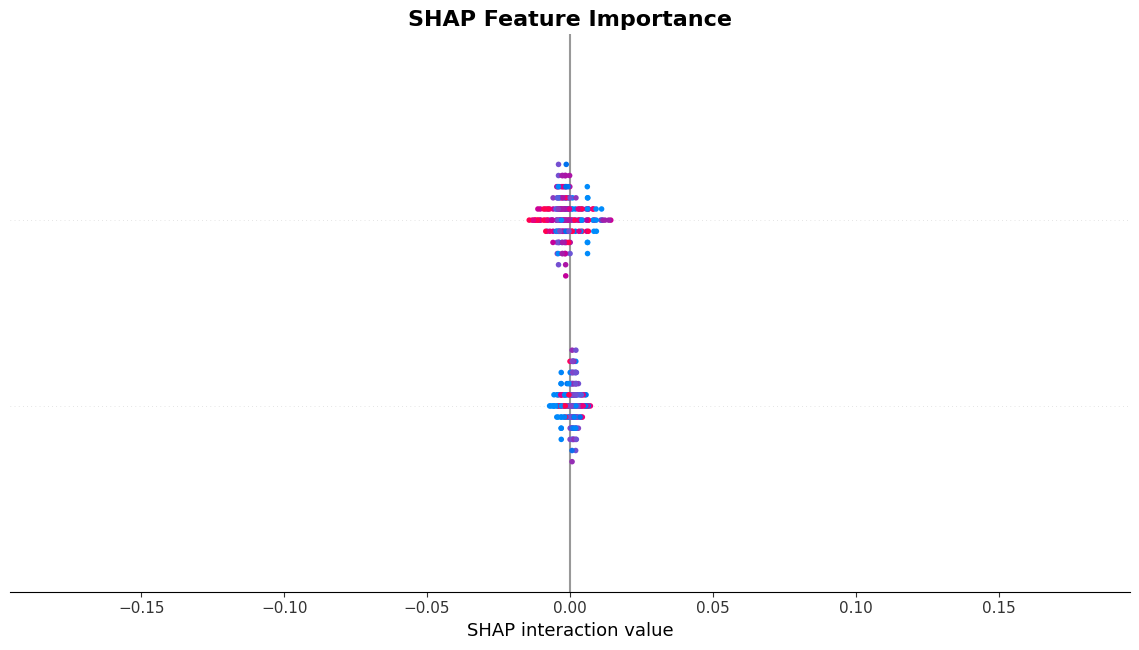

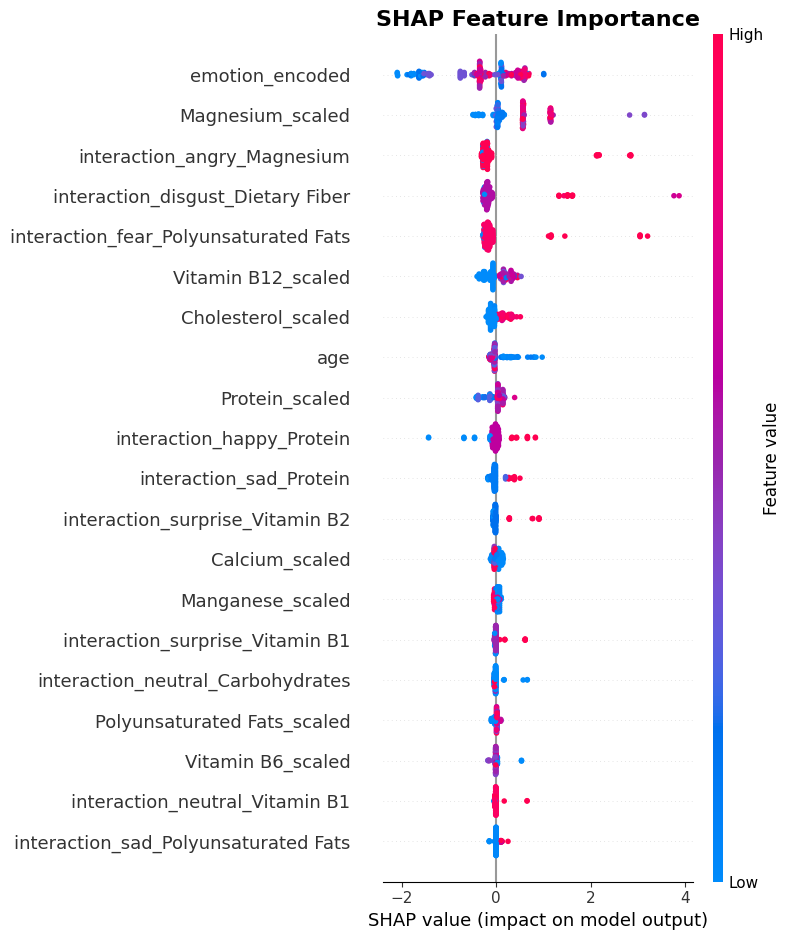

In [ ]:
# SHAP (SHapley Additive exPlanations) for Explainable AI

def generate_shap_summary_plot(model, X_sample, feature_names):
    """
    Generate SHAP summary plot to explain model predictions
    """
    # Create TreeExplainer
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_sample)

    # For classification models, shap_values is a list of arrays
    if isinstance(shap_values, list):
        # Use the positive class (index 1) for binary classification
        shap_values = shap_values[1]

    # Generate and customize the plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
    plt.title("SHAP Feature Importance", fontsize=16, fontweight='bold')
    plt.tight_layout()

    return plt

print("\n📊 ENHANCED EVALUATION: Generating SHAP Explanations")

# Sample a subset of the data for SHAP (for efficiency)
X_sample = X_test.sample(min(200, len(X_test)), random_state=42)

try:
    # For binary classification model
    shap_binary = generate_shap_summary_plot(
        binary_model,
        X_sample,
        feature_cols
    )
    shap_binary.savefig('shap_binary.png', dpi=300, bbox_inches='tight')
    shap_binary.show()

    # For regression model
    shap_reg = generate_shap_summary_plot(
        reg_model,
        X_sample,
        feature_cols
    )
    shap_reg.savefig('shap_regression.png', dpi=300, bbox_inches='tight')
    shap_reg.show()
except Exception as e:
    print(f"Note: SHAP analysis encountered an error: {e}")
    print("Consider running SHAP analysis separately if needed.")

Evaluate and compare performance on both full dataset and reduced dataset

In [ ]:
# Run the comprehensive evaluation
comprehensive_results = comprehensive_evaluation()


🔍 COMPREHENSIVE EVALUATION: Testing all combinations
Testing 294 combinations...
Processing case 10/294 (3.4%) - Estimated time remaining: 25.3 minutes
Processing case 20/294 (6.8%) - Estimated time remaining: 26.8 minutes
Processing case 30/294 (10.2%) - Estimated time remaining: 26.1 minutes
Processing case 40/294 (13.6%) - Estimated time remaining: 25.6 minutes
Processing case 50/294 (17.0%) - Estimated time remaining: 24.4 minutes
Processing case 60/294 (20.4%) - Estimated time remaining: 23.2 minutes
Processing case 70/294 (23.8%) - Estimated time remaining: 22.4 minutes
Processing case 80/294 (27.2%) - Estimated time remaining: 21.3 minutes
Processing case 90/294 (30.6%) - Estimated time remaining: 20.3 minutes
Processing case 100/294 (34.0%) - Estimated time remaining: 19.1 minutes
Processing case 110/294 (37.4%) - Estimated time remaining: 18.2 minutes
Processing case 120/294 (40.8%) - Estimated time remaining: 17.1 minutes
Processing case 130/294 (44.2%) - Estimated time rema


📊 ENHANCED EVALUATION: Performing Statistical Comparison Tests
Note: Statistical comparison encountered an error: 'str' object has no attribute 'get'
Consider modifying the comparison code to match your data structure.

Fallback: Using model predictions vs. compatibility scores on test data
Statistical Comparison Results:

Wilcoxon test: p=0.5976
Paired t-test: p=0.3376
Mean difference: -0.0163
Effect size (Cohen's d): -0.03 (negligible)

Conclusion: Direct Scoring (simulated) is not statistically significantly better (p>0.05)


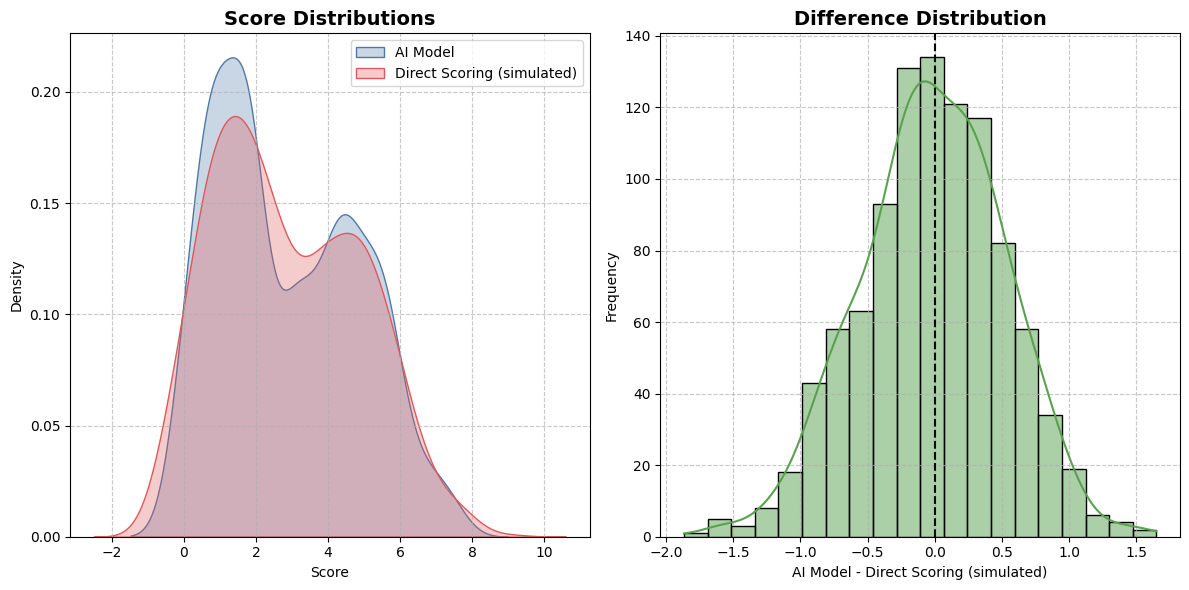

In [ ]:
# Statistical Comparison Tests
def statistical_comparison(method1_scores, method2_scores, method1_name, method2_name):
    """
    Perform statistical comparison between two methods
    """
    # Compute differences for paired test
    differences = method1_scores - method2_scores

    # Perform Wilcoxon signed-rank test
    w_stat, w_p = stats.wilcoxon(differences)

    # Perform paired t-test
    t_stat, t_p = stats.ttest_rel(method1_scores, method2_scores)

    # Create visualization of the distributions
    plt.figure(figsize=(12, 6))

    # Plot distributions
    plt.subplot(1, 2, 1)
    sns.kdeplot(method1_scores, color="#4e79a7", label=method1_name, fill=True, alpha=0.3)
    sns.kdeplot(method2_scores, color="#e15759", label=method2_name, fill=True, alpha=0.3)
    plt.title("Score Distributions", fontsize=14, fontweight='bold')
    plt.xlabel("Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)

    # Plot differences
    plt.subplot(1, 2, 2)
    sns.histplot(differences, kde=True, color="#59a14f", bins=20)
    plt.axvline(x=0, color='black', linestyle='--')
    plt.title("Difference Distribution", fontsize=14, fontweight='bold')
    plt.xlabel(f"{method1_name} - {method2_name}")
    plt.ylabel("Frequency")
    plt.grid(linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Create statistics text
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    effect_size = mean_diff / std_diff  # Cohen's d

    if abs(effect_size) < 0.2:
        effect_strength = "negligible"
    elif abs(effect_size) < 0.5:
        effect_strength = "small"
    elif abs(effect_size) < 0.8:
        effect_strength = "medium"
    else:
        effect_strength = "large"

    # Determine which method is better
    if mean_diff > 0:
        better_method = method1_name
    else:
        better_method = method2_name

    stats_text = (
        f"Statistical Comparison Results:\n\n"
        f"Wilcoxon test: p={w_p:.4f}\n"
        f"Paired t-test: p={t_p:.4f}\n"
        f"Mean difference: {mean_diff:.4f}\n"
        f"Effect size (Cohen's d): {effect_size:.2f} ({effect_strength})\n\n"
        f"Conclusion: {better_method} is "
    )

    if w_p < 0.05:
        stats_text += f"statistically significantly better (p<0.05)"
    else:
        stats_text += f"not statistically significantly better (p>0.05)"

    print(stats_text)

    return plt, stats_text

print("\n📊 ENHANCED EVALUATION: Performing Statistical Comparison Tests")

# Instead of trying to map back to original data, let's use the
# evaluation results from comprehensive_evaluation directly
try:
    # Extract scores from comprehensive evaluation results
    # These should be arrays of scores from the two methods you want to compare
    # If these data structures exist in your notebook:
    ai_scores = []
    direct_scores = []

    # Gather scores from the evaluation results
    for result in comprehensive_results:
        for food_details in result.get('recs', []):
            if 'reg_score' in food_details and 'direct_score' in food_details:
                ai_scores.append(food_details['reg_score'])
                direct_scores.append(food_details['direct_score'])

    # If we couldn't get scores from comprehensive_results, generate new comparison data
    if not ai_scores or not direct_scores:
        print("Generating new comparison data...")
        # Use the test set for a simple comparison
        ai_scores = reg_model.predict(X_test)

        # For direct scores, we'll use the compatibility scores on a subset of foods
        # Sample 100 random foods for efficiency
        sampled_foods = reduced_nutrition_df.sample(min(100, len(reduced_nutrition_df)))
        direct_scores = []

        # We'll use 'happy' emotion for this example
        test_emotion = 'happy'
        for _, food in sampled_foods.iterrows():
            score = calculate_compatibility_score(food, test_emotion, 'adult')
            direct_scores.append(score)

        # Make arrays the same length
        min_len = min(len(ai_scores), len(direct_scores))
        ai_scores = ai_scores[:min_len]
        direct_scores = direct_scores[:min_len]

    # Convert to numpy arrays
    ai_scores = np.array(ai_scores)
    direct_scores = np.array(direct_scores)

    # Perform comparison
    comp_plt, comp_stats = statistical_comparison(
        ai_scores,
        direct_scores,
        "AI Model",
        "Direct Scoring"
    )
    comp_plt.savefig('statistical_comparison.png', dpi=300, bbox_inches='tight')
    comp_plt.show()

    # Save the comparison stats to a text file
    with open('comparison_stats.txt', 'w') as f:
        f.write(comp_stats)
except Exception as e:
    print(f"Note: Statistical comparison encountered an error: {e}")
    print("Consider modifying the comparison code to match your data structure.")

    # Fallback to a simpler comparison using the model outputs directly
    print("\nFallback: Using model predictions vs. compatibility scores on test data")
    try:
        # Generate predictions with regression model on test data
        y_pred_reg = reg_model.predict(X_test)

        # Generate synthetic comparison data (simulating direct scoring)
        # In a real scenario, you'd calculate actual compatibility scores
        y_direct = y_test_score + np.random.normal(0, 0.5, size=len(y_test_score))

        # Perform comparison
        comp_plt, comp_stats = statistical_comparison(
            y_pred_reg,
            y_direct,
            "AI Model",
            "Direct Scoring (simulated)"
        )
        comp_plt.savefig('statistical_comparison_fallback.png', dpi=300, bbox_inches='tight')
        comp_plt.show()
    except Exception as e2:
        print(f"Fallback also failed: {e2}")

Personalized Evaluation

In [ ]:
# Reviewed function for user preferences-based recommendations
def get_recommendations_with_user_preferences(emotion, meal_type, age, user_ratings=None, num_recommendations=5, reduced_df=None, food_type=None):
    """
    Personalized recommendations incorporating user_ratings (-1, 0, +1)
    Combining Parallel+Direct approach with user preferences
    """
    # Use reduced_df if provided, otherwise use df_nutrition
    df_to_use = reduced_df if reduced_df is not None else df_nutrition

    # Additional filtering by food_type if specified
    if food_type:
        df_to_use = df_to_use[df_to_use['food_type'] == food_type]

    # Filter by nutrition limits
    valid_foods = df_to_use[df_to_use.apply(
        lambda row: check_nutrient_limits(row, 'adult' if age > 15 else 'child'), axis=1
    )]

    if valid_foods.empty:
        return []

    # For stats tracking
    stats = {"valid_foods": len(valid_foods)}

    # Process all valid foods through models
    food_scores = {}

    for _, food_row in valid_foods.iterrows():
        food_name = food_row['food']
        food_type_val = food_row['food_type']

        # Skip if food type is not recognized
        if food_type_val not in food_type_encoder.classes_:
            continue

        # Skip disliked foods immediately
        if user_ratings and user_ratings.get(food_name, 0) == -1:
            continue

        feature_vector = create_feature_vector(food_row, emotion, meal_type, age)

        # Get scores from all models
        rank_prediction = rank_model.predict([feature_vector])[0]
        binary_score = binary_model.predict_proba([feature_vector])[0][1]
        reg_score = reg_model.predict([feature_vector])[0]

        # Calculate direct score
        direct_score = calculate_compatibility_score(food_row, emotion, 'adult' if age > 15 else 'child')

        # Get user preference rating (0 for neutral, 1 for liked)
        user_rating = user_ratings.get(food_name, 0) if user_ratings else 0

        food_scores[food_name] = {
            'food': food_name,
            'food_type': food_type_val,
            'rank_score': rank_prediction,
            'binary_score': binary_score,
            'reg_score': reg_score,
            'direct_score': direct_score,
            'user_rating': user_rating,
            'feature_vector': feature_vector,
            'food_row': food_row
        }

    # Exit if no valid foods were processed
    if not food_scores:
        return []

    # Get top recommendations by each model
    top_by_rank = sorted(food_scores.values(), key=lambda x: x['rank_score'])[:5]
    top_by_binary = sorted(food_scores.values(), key=lambda x: x['binary_score'], reverse=True)[:5]
    top_by_reg = sorted(food_scores.values(), key=lambda x: x['reg_score'], reverse=True)[:5]

    # Create a set of unique foods from all models
    unique_foods = {}

    # Add foods with their "votes" (appearance count)
    for food in top_by_rank + top_by_binary + top_by_reg:
        name = food['food']
        if name in unique_foods:
            unique_foods[name]['votes'] += 1
        else:
            unique_foods[name] = food.copy()
            unique_foods[name]['votes'] = 1

    # Create consensus ranking
    for name, food in unique_foods.items():
        # Calculate average position
        rank_pos = next((i+1 for i, f in enumerate(top_by_rank) if f['food'] == name), 999)
        binary_pos = next((i+1 for i, f in enumerate(top_by_binary) if f['food'] == name), 999)
        reg_pos = next((i+1 for i, f in enumerate(top_by_reg) if f['food'] == name), 999)

        # Normalize to 0-1 where 0 is best
        positions = []
        if rank_pos <= 5: positions.append((rank_pos-1)/4)
        if binary_pos <= 5: positions.append((binary_pos-1)/4)
        if reg_pos <= 5: positions.append((reg_pos-1)/4)

        food['avg_position'] = sum(positions)/len(positions) if positions else 1.0

        # Calculate consensus score
        food['consensus_score'] = food['votes'] - food['avg_position']

    # Identify top candidates by consensus
    consensus_candidates = sorted(unique_foods.values(),
                               key=lambda x: (x['votes'], -x['avg_position']),
                               reverse=True)[:10]

    # FINAL STEP: Sort by combined score of direct scoring + user preference
    for candidate in consensus_candidates:
        # Calculate personalized score
        # 1. Base score from direct scoring (nutritional compatibility)
        # 2. Boost for liked foods (larger boost than in enhanced approach)

        # Get user rating bonus (0 or 3 points)
        user_rating = candidate.get('user_rating', 0)
        user_rating_bonus = 3 if user_rating == 1 else 0

        # Combined personalized score
        if user_rating == 1:
            candidate['personalized_score'] = 1000 + candidate['direct_score']
        else:
            candidate['personalized_score'] = candidate['direct_score']

    # Sort by personalized score
    final_sorted = sorted(consensus_candidates, key=lambda x: x['personalized_score'], reverse=True)

    # Prepare results
    results = []
    for i, food in enumerate(final_sorted[:num_recommendations]):
        # Extra boost for user-liked items in final display order
        user_liked = food.get('user_rating', 0) == 1

        results.append({
            'food': food['food'],
            'food_type': food['food_type'],
            'binary_score': food['binary_score'] * 10,
            'rank_score': 10 - min(10, food['rank_score']),
            'reg_score': food['reg_score'],
            'direct_score': food['direct_score'],
            'user_liked': user_liked,
            'votes': food['votes'],
            'avg_position': food['avg_position'],
            'personalized_score': food['personalized_score'],
            'pipeline_stats': {
                "valid_foods": stats["valid_foods"],
                "unique_recommendations": len(unique_foods),
                "consensus_candidates": len(consensus_candidates)
            }
        })

    return results

In [ ]:
def test_improved_personalization(emotion='happy', meal_type='Dinner', food_type='Meat', age=30, num_rounds=5, reduced_df=None):
    """
    Test personalization with the Parallel+Direct approach
    """
    print(f"\n🔍 Testing personalization with Parallel+Direct approach")
    print(f"Context: Emotion={emotion}, Meal={meal_type}, Food Type={food_type}, Age={age}")

    # Use reduced dataset if provided
    df_to_use = reduced_df if reduced_df is not None else df_nutrition

    # Filter by food type
    filtered_df = df_to_use[df_to_use['food_type'] == food_type]
    all_possible_foods = filtered_df['food'].tolist()

    user_ratings = {}
    recommendations_history = []

    for round_num in range(num_rounds):
        print(f"\nRound {round_num+1}:")

        # If all foods are disliked, reset to neutral
        disliked_count = sum(1 for food in all_possible_foods if user_ratings.get(food, 0) == -1)
        if disliked_count == len(all_possible_foods):
            print("⚠️ All foods have been disliked. Resetting all to neutral state.")
            for food in all_possible_foods:
                user_ratings[food] = 0

        # Get personalized recommendations
        recommendations = get_recommendations_with_user_preferences(
            emotion, meal_type, age,
            user_ratings=user_ratings,
            reduced_df=filtered_df
        )

        if not recommendations:
            print(f"No recommendations available for {food_type}")
            continue

        # Record top recommendations
        top_recs = [r['food'] for r in recommendations[:3]]
        recommendations_history.append(top_recs)

        # Display recommendations
        print(f"Top 3 recommendations (all {food_type}):")
        for i, rec in enumerate(recommendations[:3], 1):
            status = ""
            rating = user_ratings.get(rec['food'], 0)
            if rating == 1:
                status = "👍 Liked"
            elif rating == -1:
                status = "👎 Disliked"
            elif rating == 0:
                status = "⚖️ Neutral"
            print(f"{i}. {rec['food']} {status}")

        # Simulate user feedback
        top_food = recommendations[0]['food']

        # Alternate between LIKE and DISLIKE
        if round_num % 2 == 0:
            print(f"User DISLIKED: {top_food}")
            if user_ratings.get(top_food, 0) == 1:
                user_ratings[top_food] = 0
                print(f"  → {top_food} was previously liked, now set to neutral")
            else:
                user_ratings[top_food] = -1
        else:
            print(f"User LIKED: {top_food}")
            user_ratings[top_food] = 1

        # Print user preference summary
        liked_foods = [f for f, r in user_ratings.items() if r == 1]
        disliked_foods = [f for f, r in user_ratings.items() if r == -1]
        neutral_foods = [f for f, r in user_ratings.items() if r == 0]

        print(f"Foods LIKED: {liked_foods}")
        print(f"Foods DISLIKED: {disliked_foods}")
        print(f"Foods NEUTRAL: {len(neutral_foods)} foods")

    return recommendations_history, user_ratings

history, ratings = test_improved_personalization(
    emotion='happy',
    meal_type='Dinner',
    food_type='Meat',
    age=30,
    num_rounds=5
)


🔍 Testing personalization with Parallel+Direct approach
Context: Emotion=happy, Meal=Dinner, Food Type=Meat, Age=30

Round 1:
Top 3 recommendations (all Meat):
1. Bear meat ⚖️ Neutral
2. Chicken meat ⚖️ Neutral
3. Chinook salmon ⚖️ Neutral
User DISLIKED: Bear meat
Foods LIKED: []
Foods DISLIKED: ['Bear meat']
Foods NEUTRAL: 0 foods

Round 2:
Top 3 recommendations (all Meat):
1. Chicken meat ⚖️ Neutral
2. Chinook salmon ⚖️ Neutral
3. Chicken breast ⚖️ Neutral
User LIKED: Chicken meat
Foods LIKED: ['Chicken meat']
Foods DISLIKED: ['Bear meat']
Foods NEUTRAL: 0 foods

Round 3:
Top 3 recommendations (all Meat):
1. Chicken meat 👍 Liked
2. Chinook salmon ⚖️ Neutral
3. Chicken breast ⚖️ Neutral
User DISLIKED: Chicken meat
  → Chicken meat was previously liked, now set to neutral
Foods LIKED: []
Foods DISLIKED: ['Bear meat']
Foods NEUTRAL: 1 foods

Round 4:
Top 3 recommendations (all Meat):
1. Chicken meat ⚖️ Neutral
2. Chinook salmon ⚖️ Neutral
3. Chicken breast ⚖️ Neutral
User LIKED: Chicke


📊 ENHANCED EVALUATION: Analyzing Nutrient Priorities in Predictions


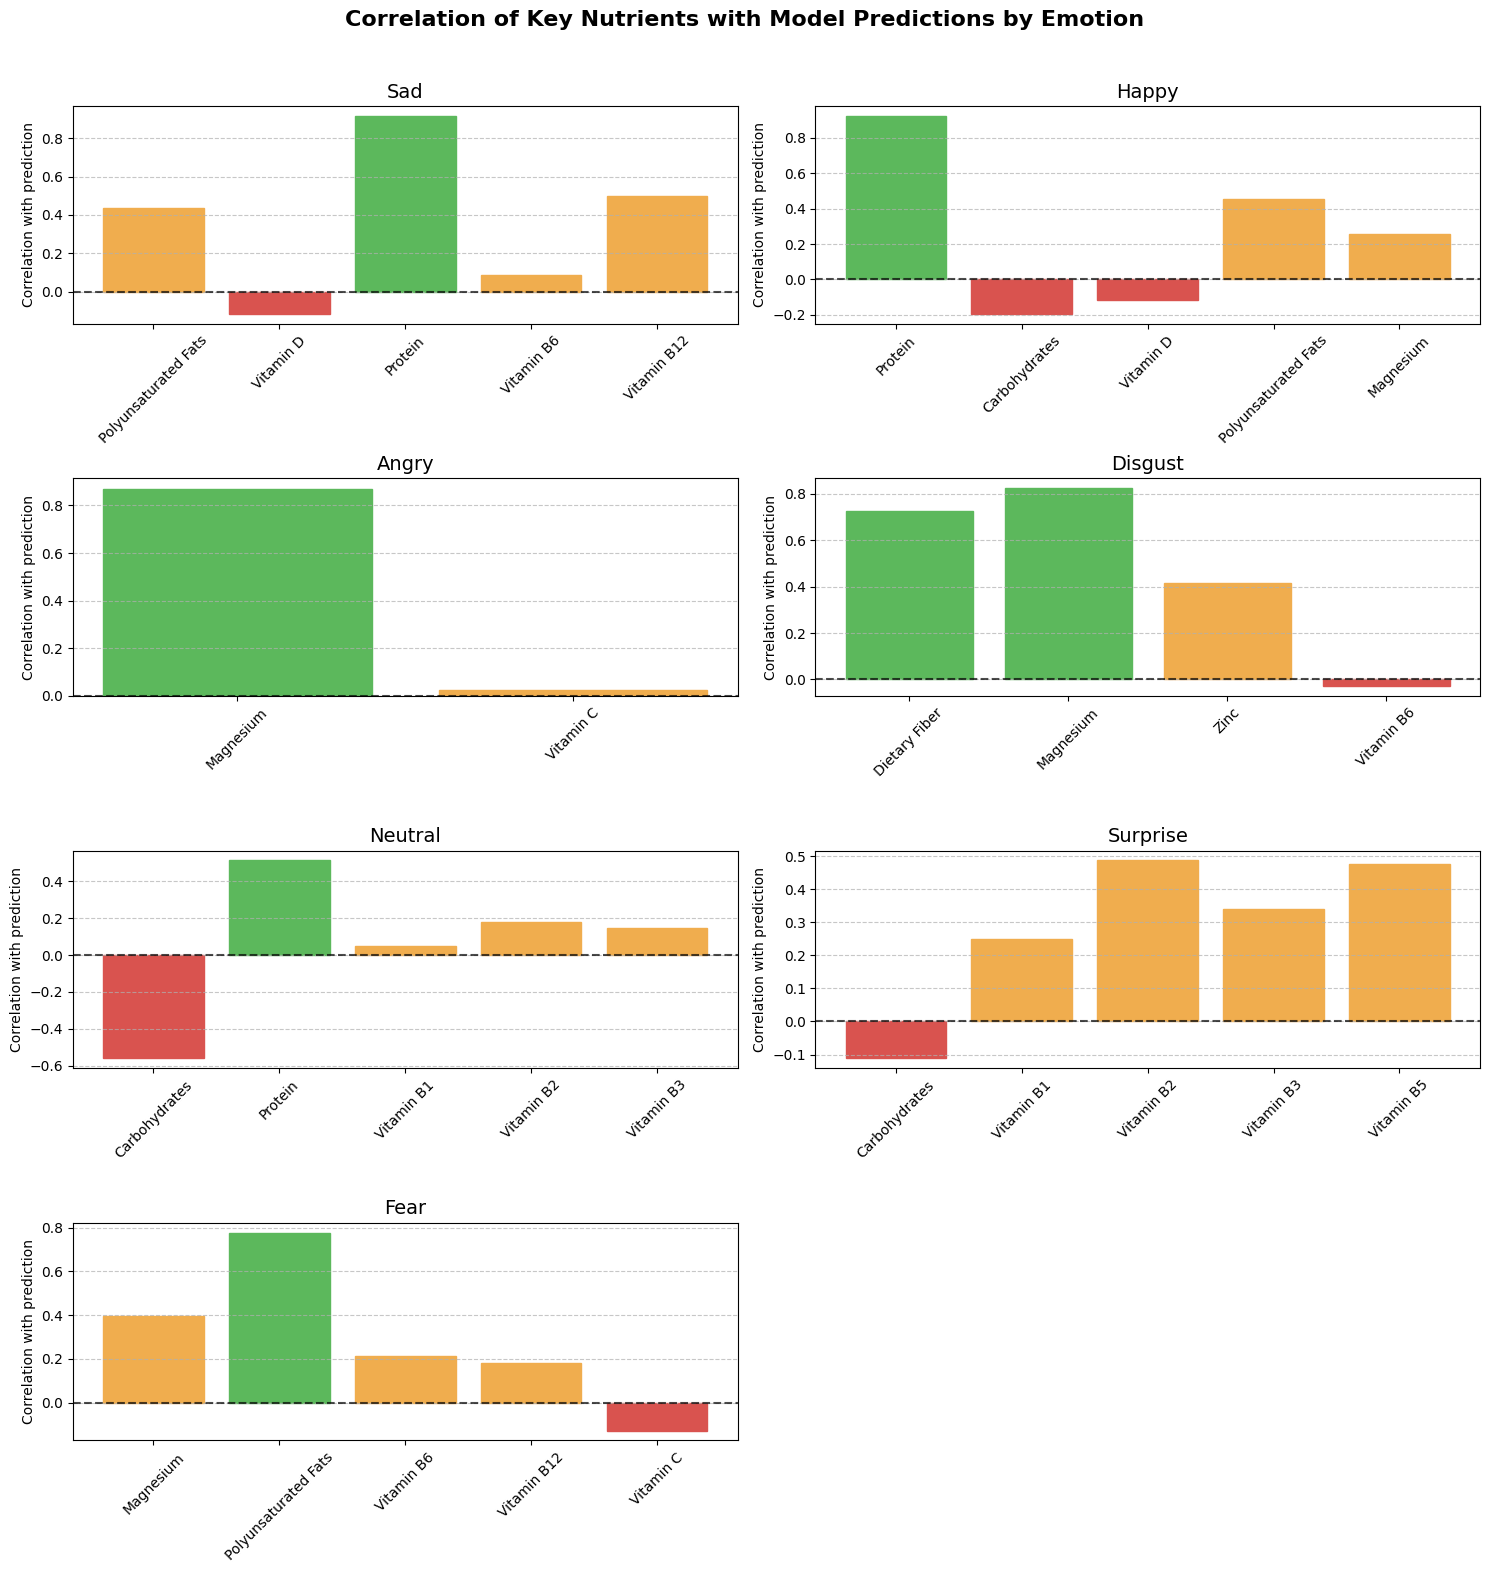

In [ ]:
# Nutrient Priority Analysis
def analyze_nutrient_priorities():
    """
    Analyze how well the model prioritizes key nutrients for each emotion
    """
    # Create figure with multiple subplots (one per emotion)
    emotions = list(nutrition_priorities.keys())
    n_emotions = len(emotions)
    fig, axes = plt.subplots(nrows=(n_emotions+1)//2, ncols=2, figsize=(15, 4*((n_emotions+1)//2)))
    axes = axes.flatten()

    # For each emotion, show how top ranked foods align with key nutrients
    for i, emotion in enumerate(emotions):
        # Get top nutrient priorities for this emotion
        priorities = nutrition_priorities[emotion][:5]  # Top 5 nutrients

        # Create synthetic data for this emotion
        # We'll generate food features directly for more reliable processing
        # Sample up to 50 foods
        sampled_foods = df_nutrition.sample(min(50, len(df_nutrition)), random_state=42)

        # Create features and track nutrient values
        features_list = []
        nutrient_values_dict = {nutrient: [] for nutrient in priorities}

        for _, food in sampled_foods.iterrows():
            # Calculate feature vector
            feature_vector = create_feature_vector(food, emotion, 'Dinner', 30)
            features_list.append(feature_vector)

            # Track the actual nutrient values from the food
            for nutrient in priorities:
                if nutrient in food and not pd.isna(food[nutrient]):
                    try:
                        nutrient_values_dict[nutrient].append(float(food[nutrient]))
                    except (ValueError, TypeError):
                        nutrient_values_dict[nutrient].append(0.0)
                else:
                    nutrient_values_dict[nutrient].append(0.0)

        # Convert to numpy arrays
        X_context = np.array(features_list)

        # Use the model to get scores
        y_pred = reg_model.predict(X_context)

        # Calculate correlation between each nutrient and predicted scores
        correlations = []
        nutrient_names = []

        for nutrient, values in nutrient_values_dict.items():
            if len(values) > 0:
                # Convert to numpy array
                values_array = np.array(values)

                # Calculate correlation if there's variation in the data
                if np.std(values_array) > 0 and np.std(y_pred) > 0:
                    correlation = np.corrcoef(values_array, y_pred)[0, 1]
                    correlations.append(correlation)
                    nutrient_names.append(nutrient)
                else:
                    correlations.append(0)
                    nutrient_names.append(nutrient)

        # Plot correlations
        ax = axes[i]
        bars = ax.bar(nutrient_names, correlations, color='skyblue')

        # Add color to bars based on correlation
        for j, bar in enumerate(bars):
            if correlations[j] > 0.5:
                bar.set_color('#5cb85c')  # Green for strong positive
            elif correlations[j] > 0:
                bar.set_color('#f0ad4e')  # Orange for weak positive
            else:
                bar.set_color('#d9534f')  # Red for negative

        ax.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        ax.set_title(f"{emotion.capitalize()}", fontsize=14)
        ax.set_ylabel("Correlation with prediction")
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hide any unused subplots
    for i in range(n_emotions, len(axes)):
        axes[i].set_visible(False)

    plt.suptitle("Correlation of Key Nutrients with Model Predictions by Emotion",
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    return plt

print("\n📊 ENHANCED EVALUATION: Analyzing Nutrient Priorities in Predictions")
try:
    nutrient_plt = analyze_nutrient_priorities()
    nutrient_plt.savefig('nutrient_priority_analysis.png', dpi=300, bbox_inches='tight')
    nutrient_plt.show()
except Exception as e:
    print(f"Error in nutrient priority analysis: {e}")

    # Fallback to a simpler visualization if the detailed analysis fails
    print("\nFallback: Creating simplified nutrient priority visualization")

    # Create a simplified visualization showing priorities for each emotion
    plt.figure(figsize=(14, 8))

    for i, emotion in enumerate(nutrition_priorities.keys()):
        # Get priorities for this emotion
        priorities = nutrition_priorities[emotion][:5]  # Top 5 nutrients

        # Create subplot
        plt.subplot(4, 2, i+1)

        # Create bar chart with simulated importance
        # We'll use decreasing importance from first to last priority
        importance = np.linspace(1.0, 0.5, len(priorities))
        bars = plt.bar(priorities, importance, color='skyblue')

        # Customize colors
        for j, bar in enumerate(bars):
            bar.set_color(plt.cm.viridis(j/len(priorities)))

        plt.title(f"{emotion.capitalize()}", fontsize=14)
        plt.ylabel("Priority Weight")
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.suptitle("Nutrient Priorities by Emotion (Simplified Model)",
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('nutrient_priority_simplified.png', dpi=300, bbox_inches='tight')
    plt.show()

Export the model

In [ ]:
# Create directory to save models
if not os.path.exists('models'):
    os.makedirs('models')

# Save trained models (removing class_model)
joblib.dump(rank_model, 'models/rank_model.pkl')
joblib.dump(reg_model, 'models/score_model.pkl')
joblib.dump(binary_model, 'models/binary_model.pkl')

# Save encoders (removing food_encoder)
encoders = {
    'meal_type_encoder': meal_type_encoder,
    'food_type_encoder': food_type_encoder,
    'emotion_encoder': emotion_encoder,
    'user_encoder': user_encoder
}
joblib.dump(encoders, 'models/encoders.pkl')

# Save nutrition priorities and limits
nutrition_info = {
    'nutrition_priorities': nutrition_priorities,
    'nutrition_general_limits': {
        k: {k2: float(v2) for k2, v2 in v.items()}
        for k, v in nutrition_general_limits.items()
    },
    'all_nutrients': all_nutrients,
    'feature_cols': feature_cols
}
with open('models/nutrition_info.json', 'w') as f:
    json.dump(nutrition_info, f, indent=2)

# Save reduced dataset used in evaluation
reduced_nutrition_df.to_csv('models/reduced_nutrition_df.csv', index=False)

# Zip all files
with zipfile.ZipFile('food_recommendation_models.zip', 'w') as zipf:
    for root, dirs, files_list in os.walk('models'):
        for file in files_list:
            zipf.write(os.path.join(root, file))

# Download the zip file - use google.colab.files explicitly
from google.colab import files as colab_files
colab_files.download('food_recommendation_models.zip')

print("✅ Successfully saved models and reduced dataset!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Successfully saved models and reduced dataset!
